In [1]:
import sys
sys.path.append('../../')
from src.load_data import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

In [4]:
TEST_YEAR = 2019

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    # use_static_covariates=True,
    add_encoders=ENCODERS,
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

# Load best parameters

In [6]:
params = get_best_parameters('lightgbm', 2019, use_covariates=False)

WIS of best run: 264.88310900740055


In [7]:
params = get_best_parameters('hp-tuning', 'lightgbm', test_year=2019)

WIS of best run: 264.2717554490951


In [8]:
name = params.pop('model')
test_year = params.pop('test_year')
# optimizer = params.pop('optimizer')
use_covariates = params.pop('use_covariates')
multiple_series = params.pop('multiple_series')

In [9]:
if not use_covariates:
    del params['lags_past_covariates']

In [10]:
# name = params.pop('model')
# test_year = params.pop('test_year')
# optimizer = params.pop('optimizer')
# use_covariates = params.pop('use_covariates')

In [11]:
# params['optimizer_cls'] = OPTIMIZER_DICT[optimizer]

In [12]:
params

{'lags': 4,
 'max_bin': 510,
 'max_depth': 5,
 'reg_alpha': 0.5,
 'subsample': 1,
 'num_leaves': 50,
 'reg_lambda': 0,
 'n_estimators': 100,
 'learning_rate': 0.2,
 'min_split_gain': 0,
 'subsample_freq': 1,
 'colsample_bytree': 0.9,
 'min_child_samples': 10,
 'use_static_covariates': True,
 'lags_future_covariates': [0, 4]}

In [15]:
model = TSMixerModel(
    **params,
    **SHARED_ARGS
)

In [10]:
model = TFTModel(
    **params,
    **SHARED_ARGS
)

In [54]:
params['n_estimators'] = 5000

In [55]:
model = LightGBMModel(
    **params,
    output_chunk_length=4,
    add_encoders=ENCODERS,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1
)

In [82]:
model = LightGBMModel(output_chunk_length=4,
               lags=12,
               n_estimators=1000,
               #lags_past_covariates=12,
               lags_future_covariates=(0,4),
               add_encoders=ENCODERS,
               use_static_covariates=True,
               # categorical_static_covariates=['location', 'age_group'],
               verbose=-1,
               likelihood="quantile",
               quantiles=QUANTILES,
               #min_child_samples=10
               )

# Load data

In [56]:
targets_train, targets_test, covariates = get_test_data(TEST_YEAR)

<Axes: xlabel='date'>

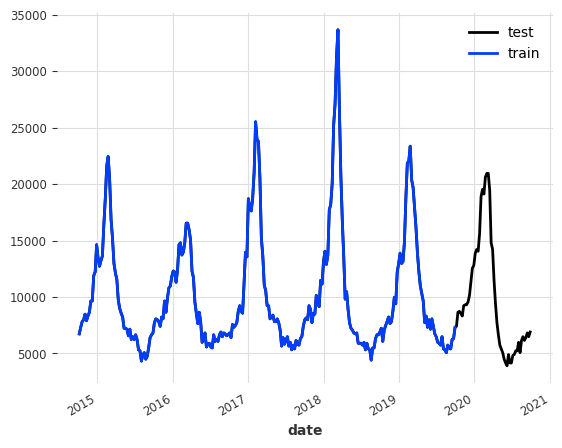

In [57]:
targets_test['icosari-sari-DE'].plot(label='test')
targets_train['icosari-sari-DE'].plot(label='train')

In [58]:
if multiple_series:
    targets_train = [targets_train[col] for col in targets_train.columns]
    targets_test = [targets_test[col] for col in targets_test.columns]
    covariates = [covariates]*len(targets_train)

In [59]:
# targets_train = [targets_train[col] for col in targets_train.columns]
# targets_test = [targets_test[col] for col in targets_test.columns]

# Train model

In [60]:
HFC_PATH = f'../../data/pre-covid/cv-test-{name}-{test_year}.csv'
MODEL_PATH = f'../../models/pre-covid/cv-test-{name}-{test_year}.pt'

In [61]:
MODEL_PATH

'../../models/pre-covid/cv-test-lightgbm-2019.pt'

In [62]:
# use_covariates = False

In [63]:
# model.reset_model()
model.fit(targets_train, past_covariates=covariates if use_covariates else None)

LightGBMModel(lags=4, lags_past_covariates=None, lags_future_covariates=[0, 4], output_chunk_length=4, output_chunk_shift=0, add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, likelihood=quantile, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None, max_bin=510, max_depth=5, reg_alpha=0.5, subsample=1, num_leaves=50, reg_lambda=0, n_estimators=5000, learning_rate=0.2, min_split_gain=0, subsample_freq=1, colsample_bytree=0.9, min_child_samples=10, verbose=-1)

In [64]:
if multiple_series:
    test_start = targets_train[0].end_time() + targets_train[0].freq
else:
    test_start = targets_train.end_time() + targets_train.freq

In [65]:
hfc = model.historical_forecasts(
    series=targets_test,
    past_covariates=covariates if use_covariates else None,
    start=test_start,
    forecast_horizon=HORIZON,
    stride=1,
    last_points_only=False,
    retrain=False,
    verbose=False,
    num_samples=NUM_SAMPLES,
    enable_optimization=False
)

In [66]:
df = reshape_hfc(hfc)

In [67]:
# df.to_csv(HFC_PATH, index=False)
# print(HFC_PATH)

In [68]:
# df = pd.read_csv(HFC_PATH)
# print(HFC_PATH)

In [69]:
if multiple_series:
    df_plot = prepare_plot_data(df, concatenate(targets_test, axis='component')[test_start : ])
else:
    df_plot = prepare_plot_data(df, targets_test[test_start : ])

In [70]:
use_covariates, multiple_series

(False, True)

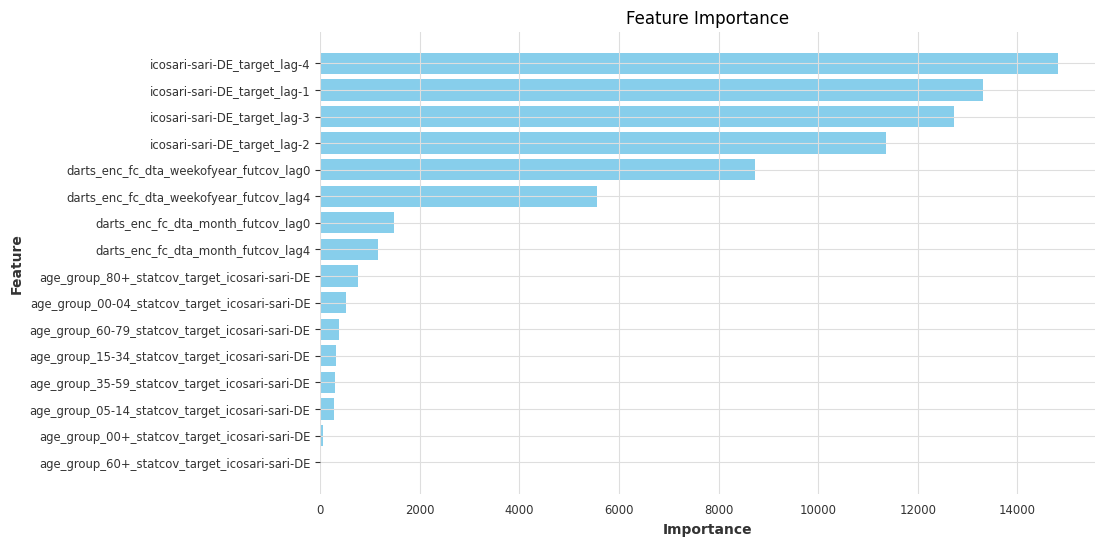

In [73]:
plot_importance_lgbm(model, horizon=3, max_features=20, y_size=6)

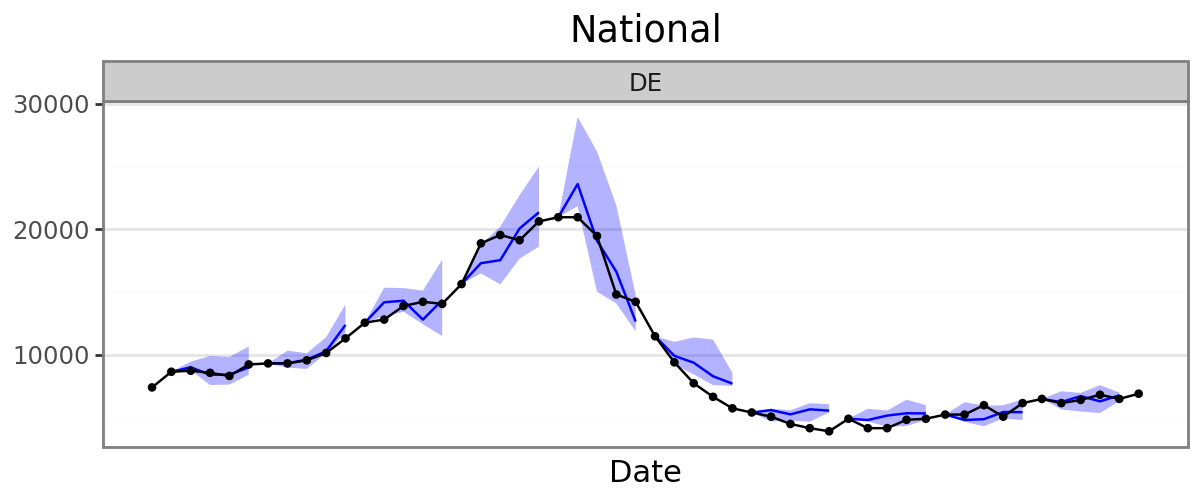

In [71]:
plot_forecasts(df_plot, 'national', 2)

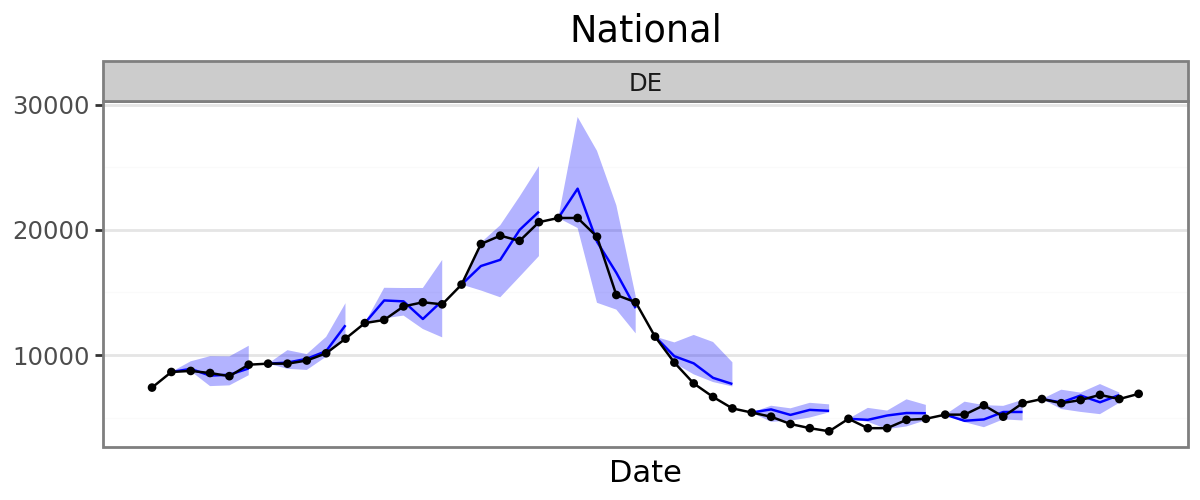

In [52]:
plot_forecasts(df_plot, 'national', 2)

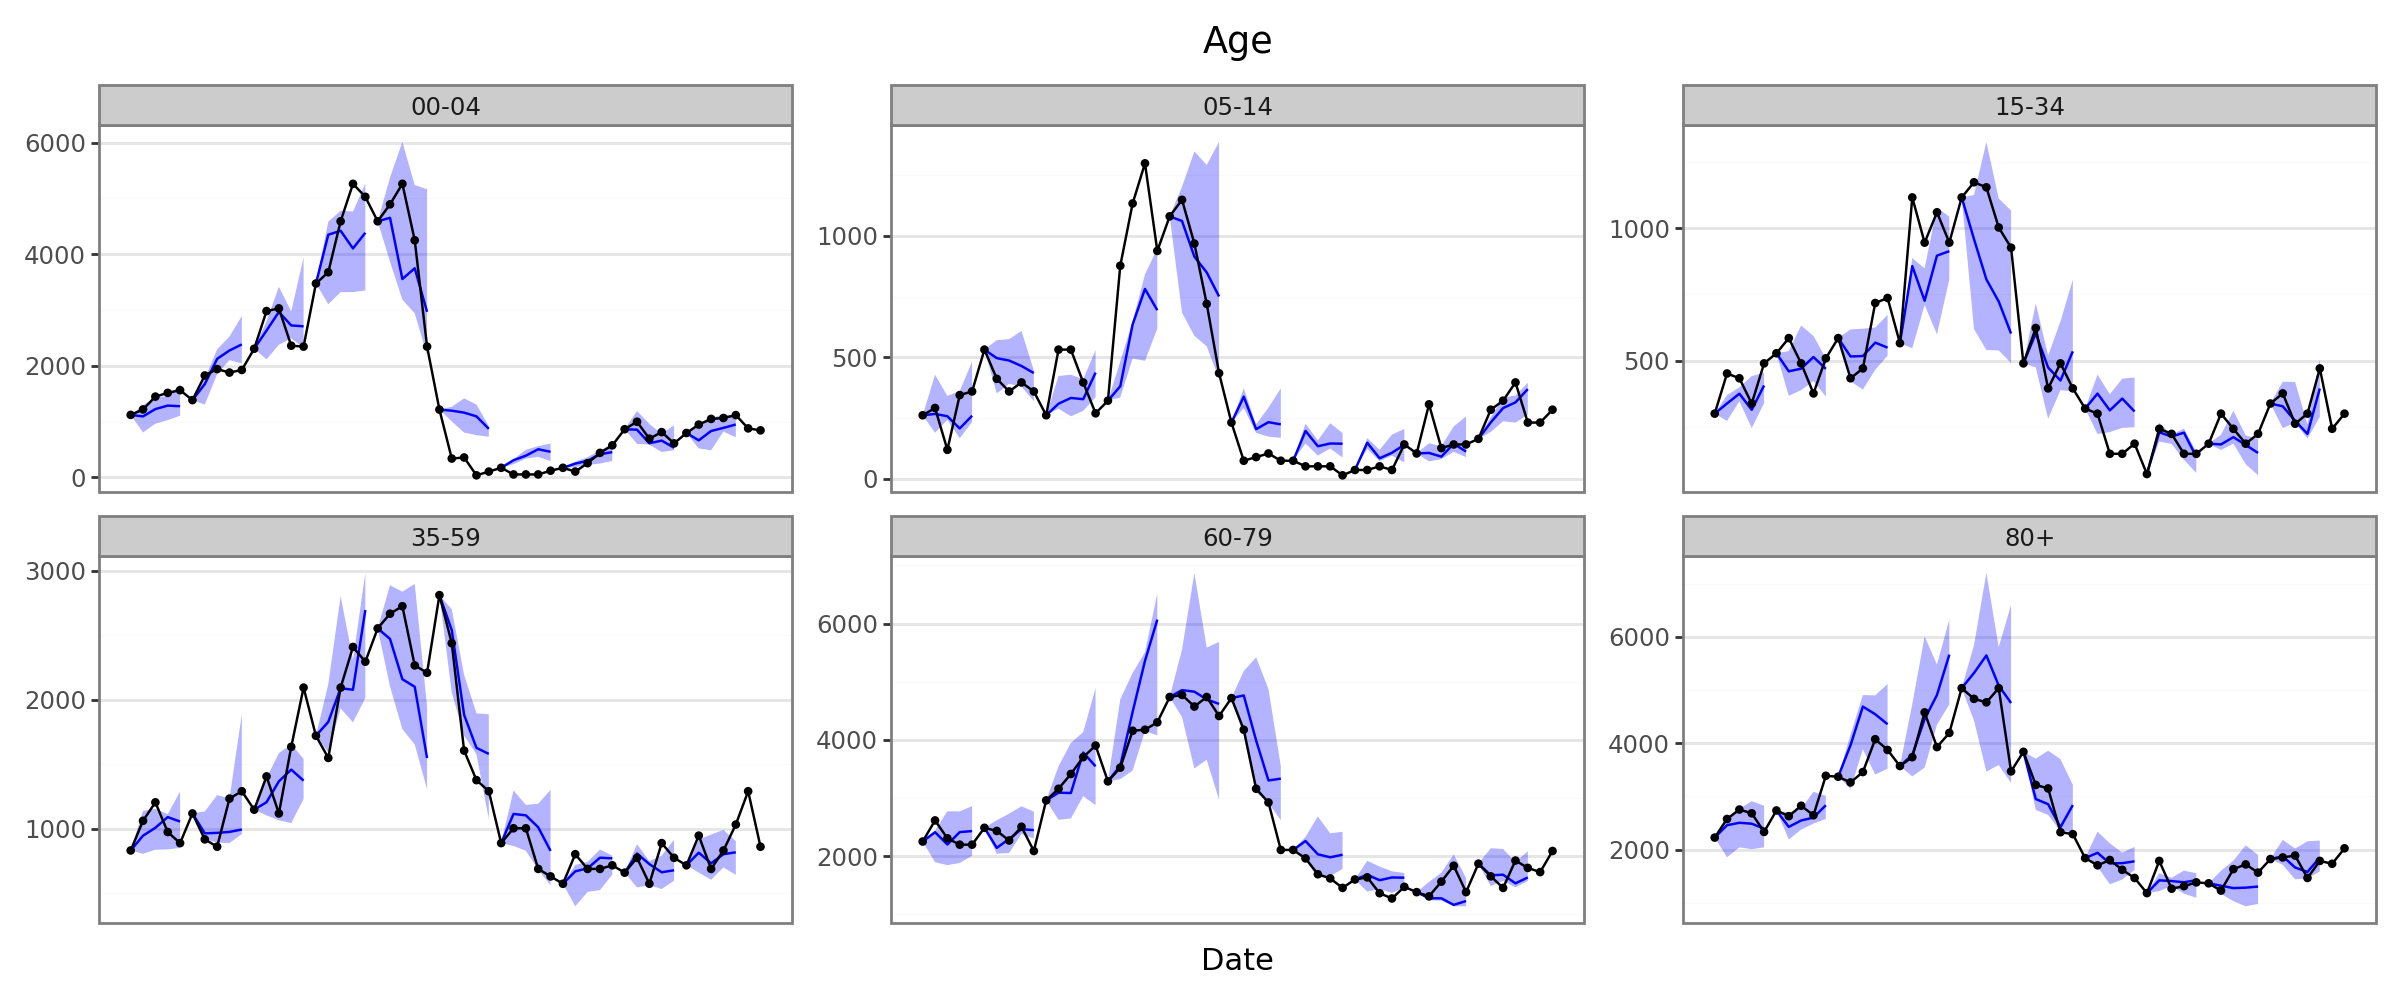

In [72]:
plot_forecasts(df_plot, 'age', 1)

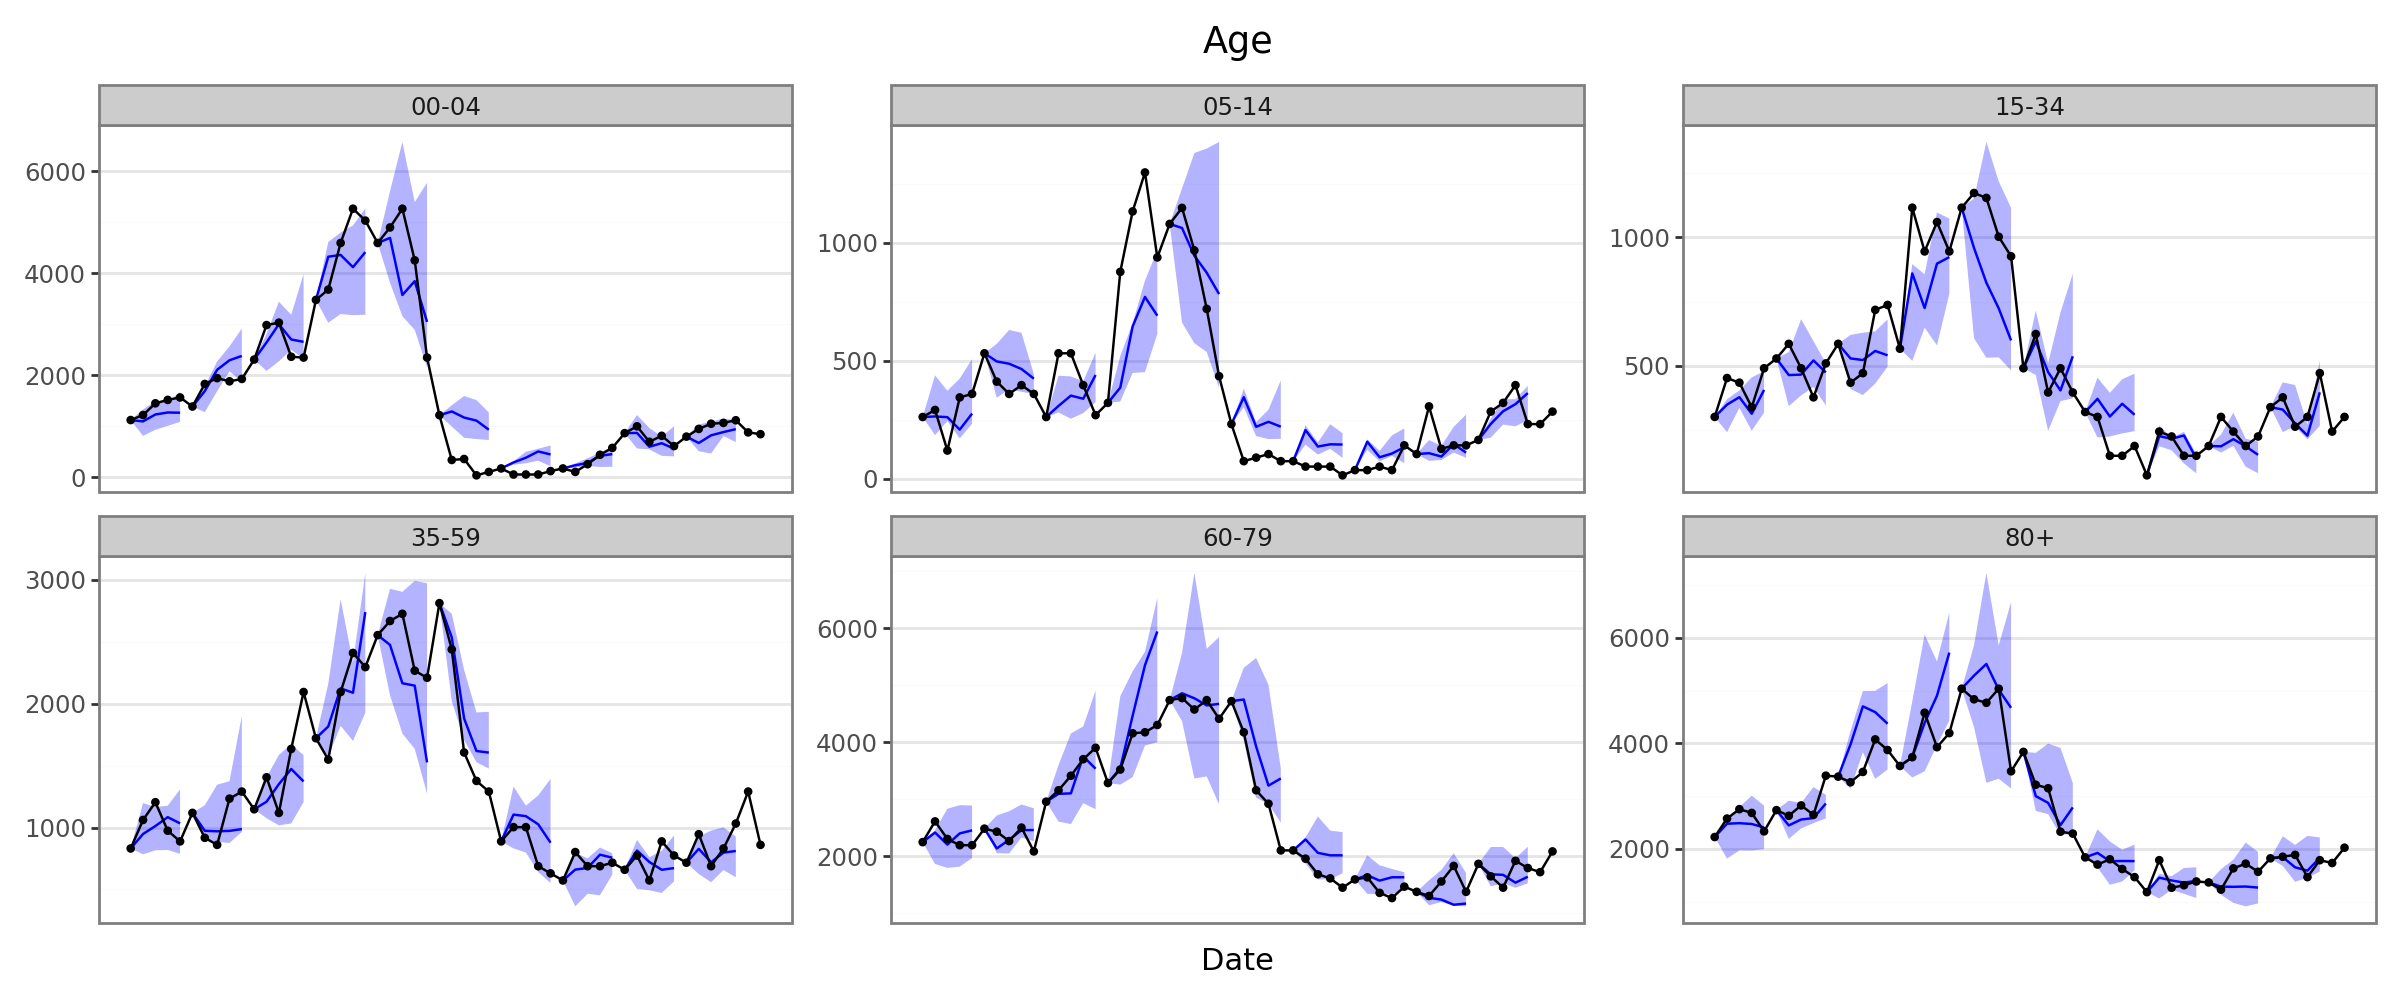

In [53]:
plot_forecasts(df_plot, 'age', 1)

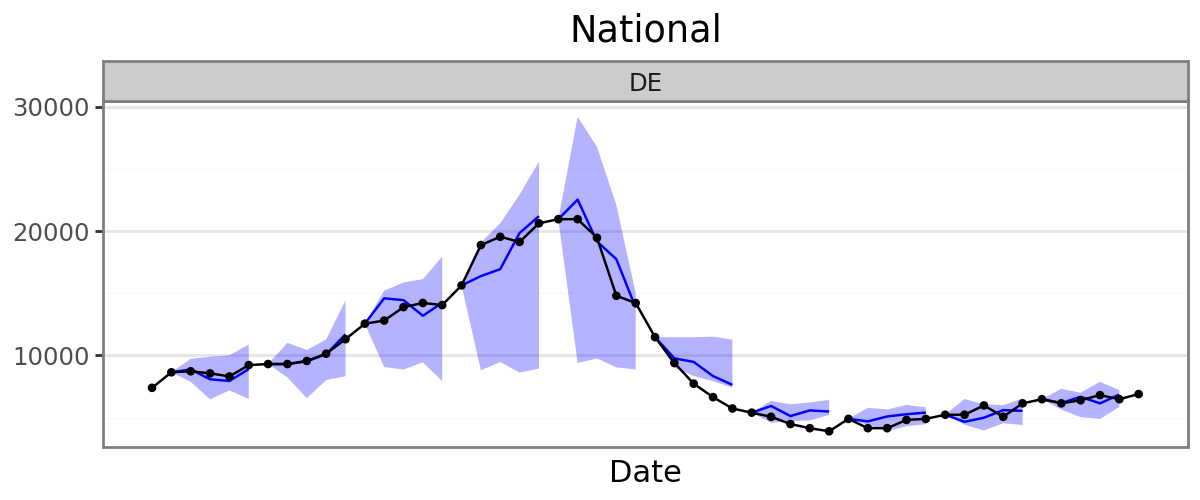

In [27]:
plot_forecasts(df_plot, 'national', 2)

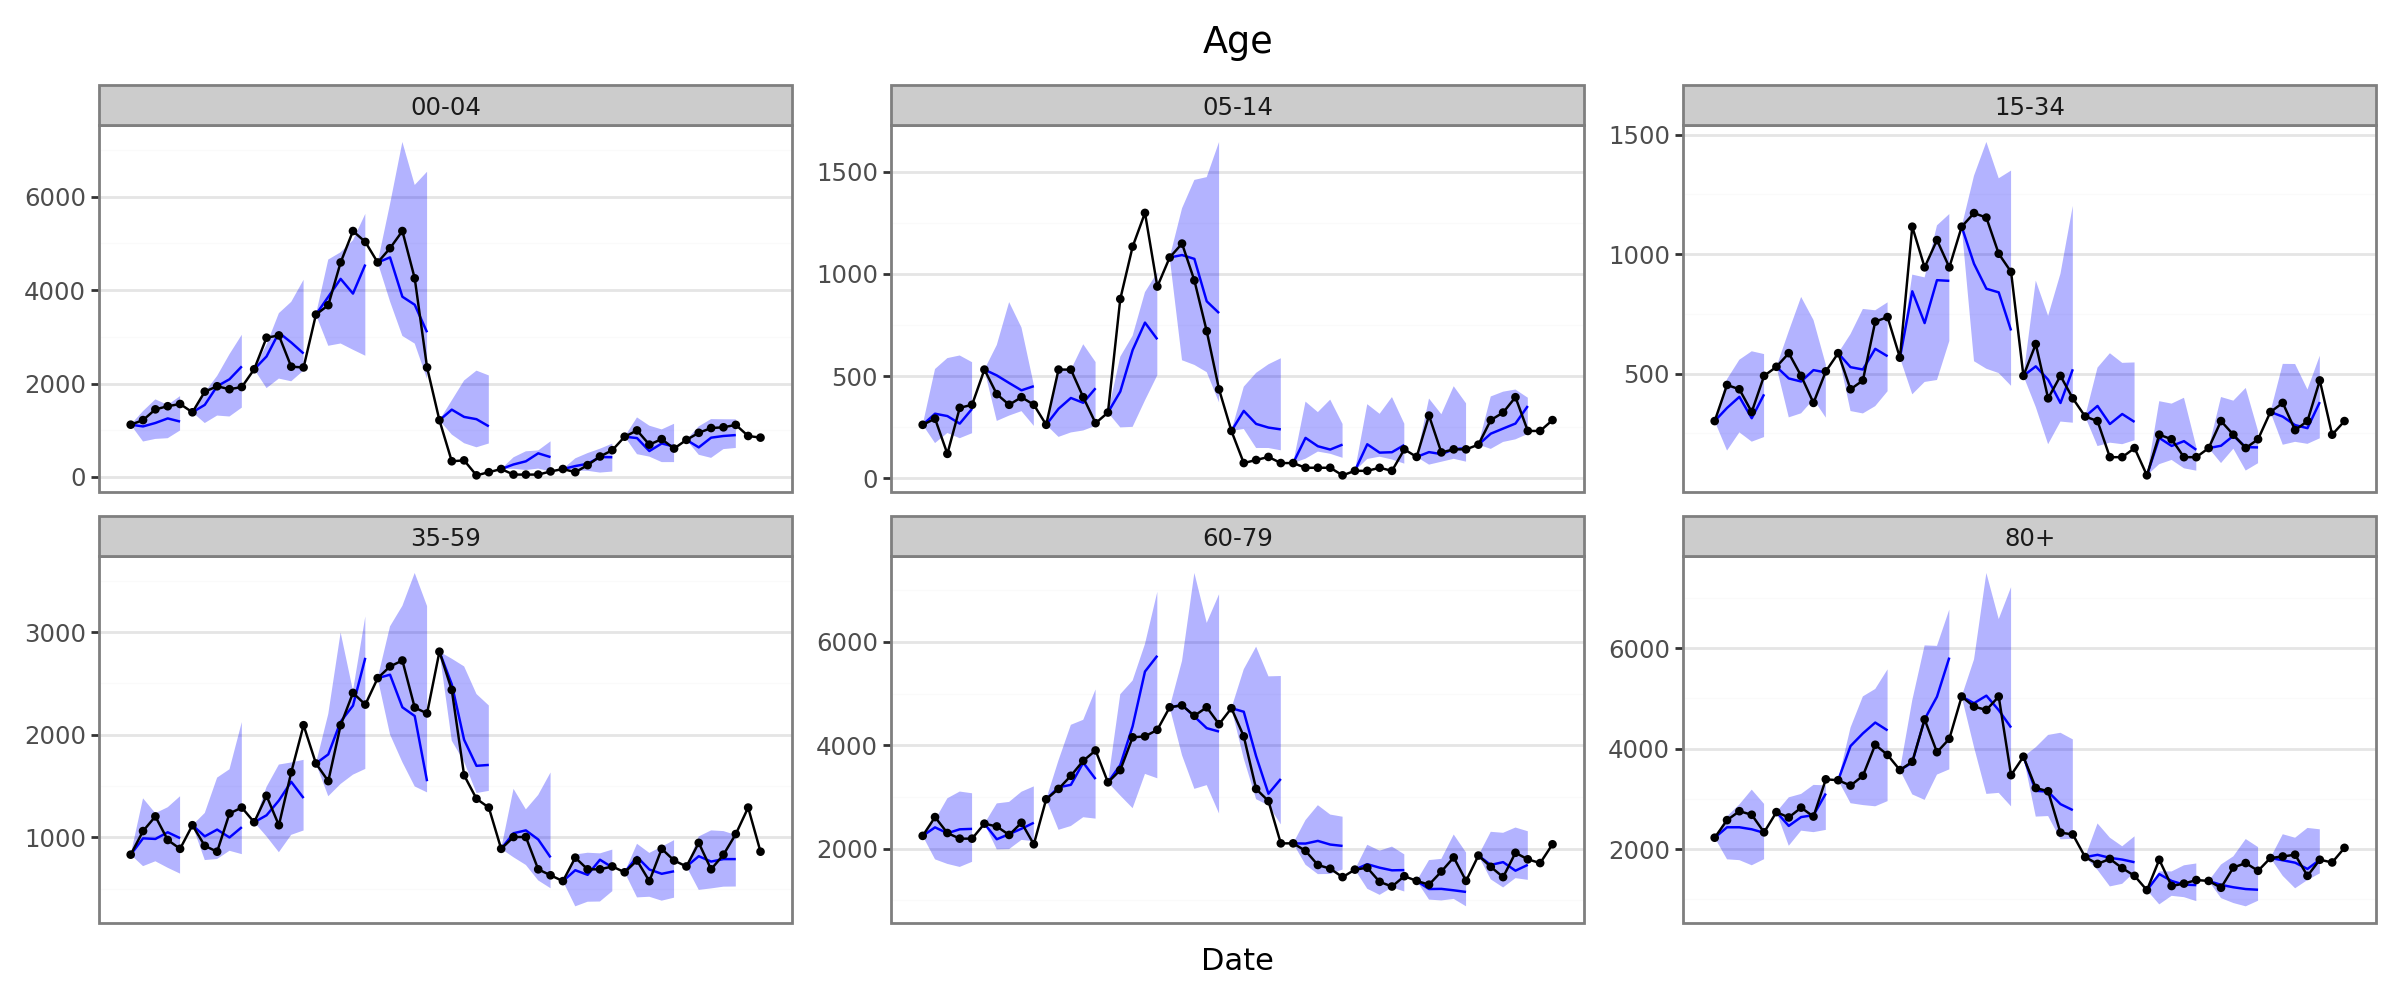

In [28]:
plot_forecasts(df_plot, 'age', 1)

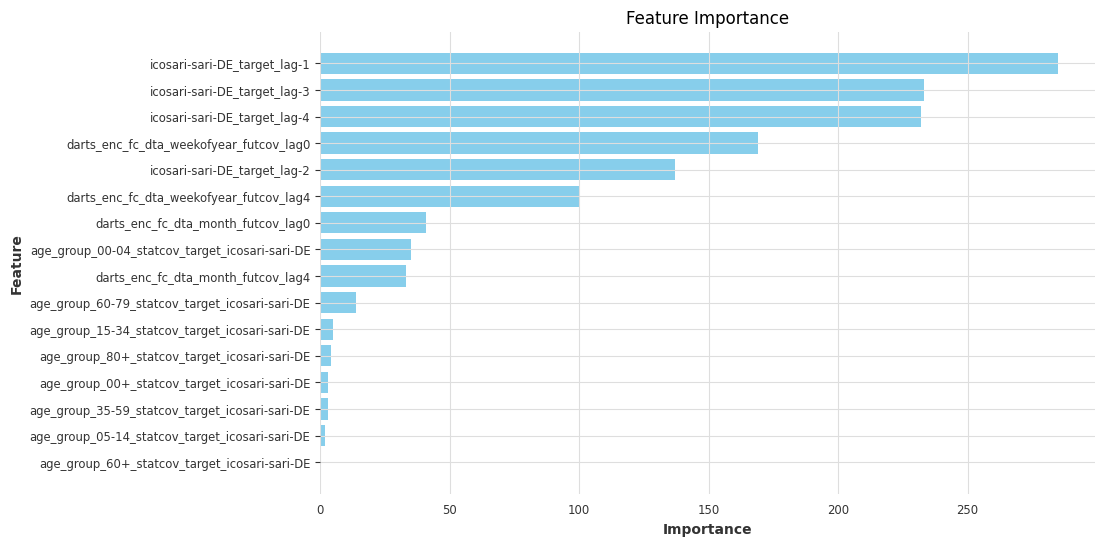

In [30]:
plot_importance_lgbm(model, horizon=3, max_features=20, y_size=6)

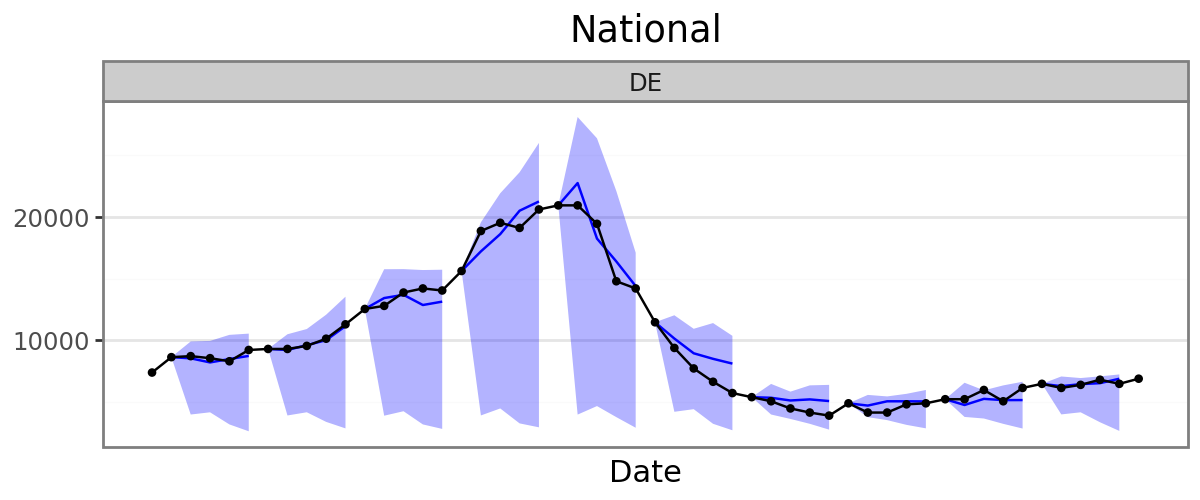

In [39]:
# global, no covariates (best) 

plot_forecasts(df_plot, 'national', 2)

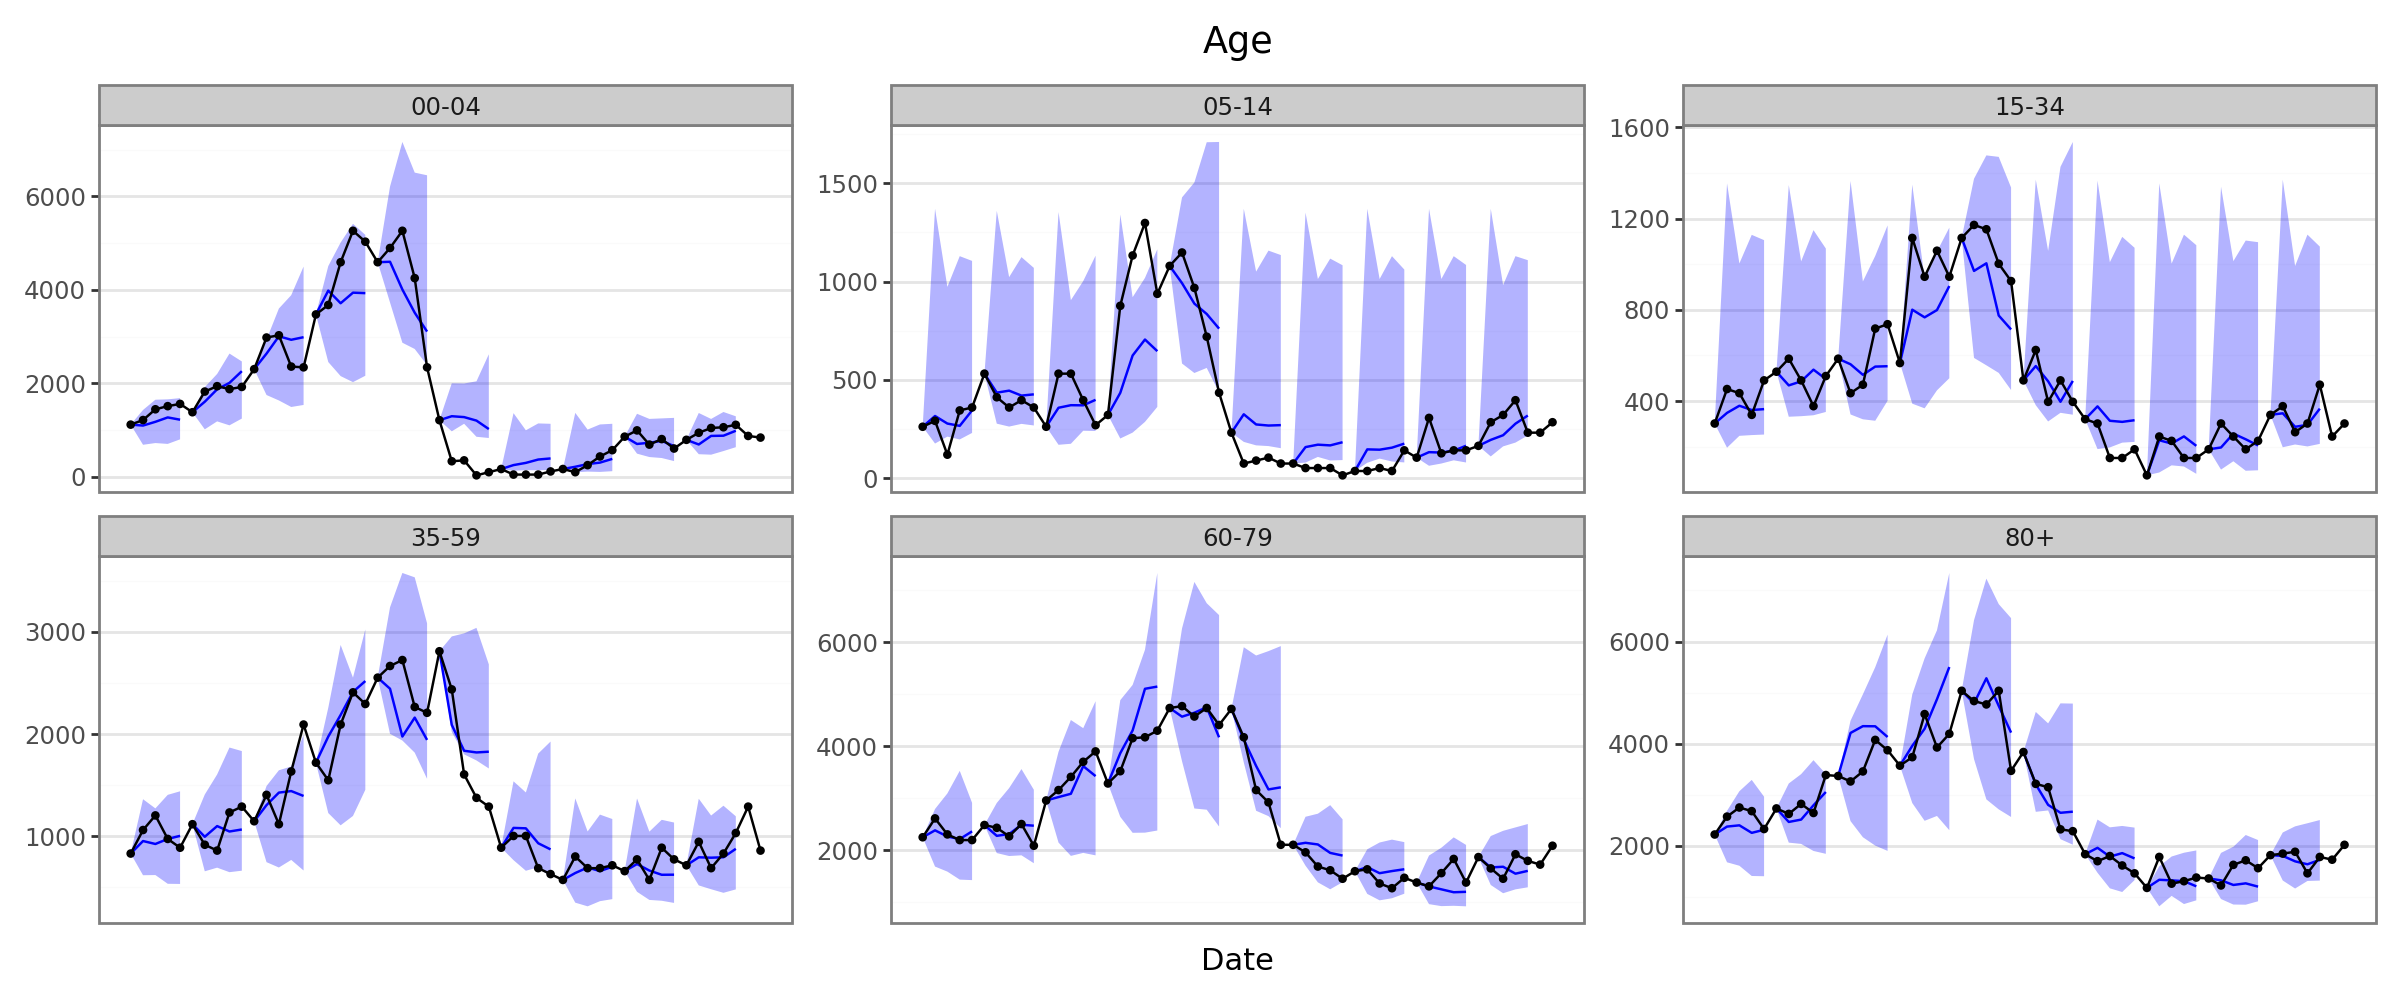

In [29]:
# global, no covariates
plot_forecasts(df_plot, 'age', 1)

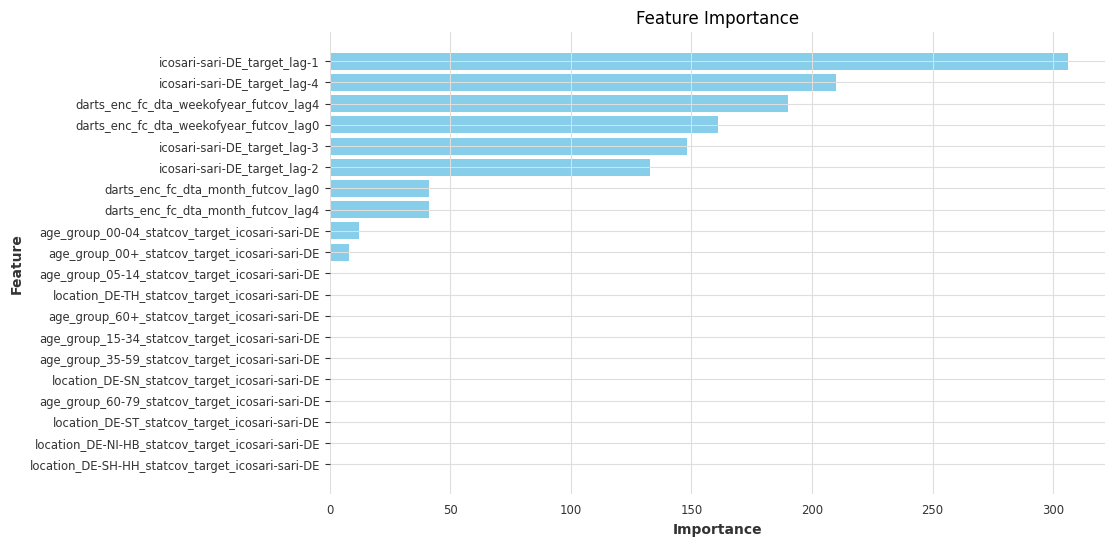

In [36]:
plot_importance_lgbm(model, horizon=3, max_features=20, y_size=6)

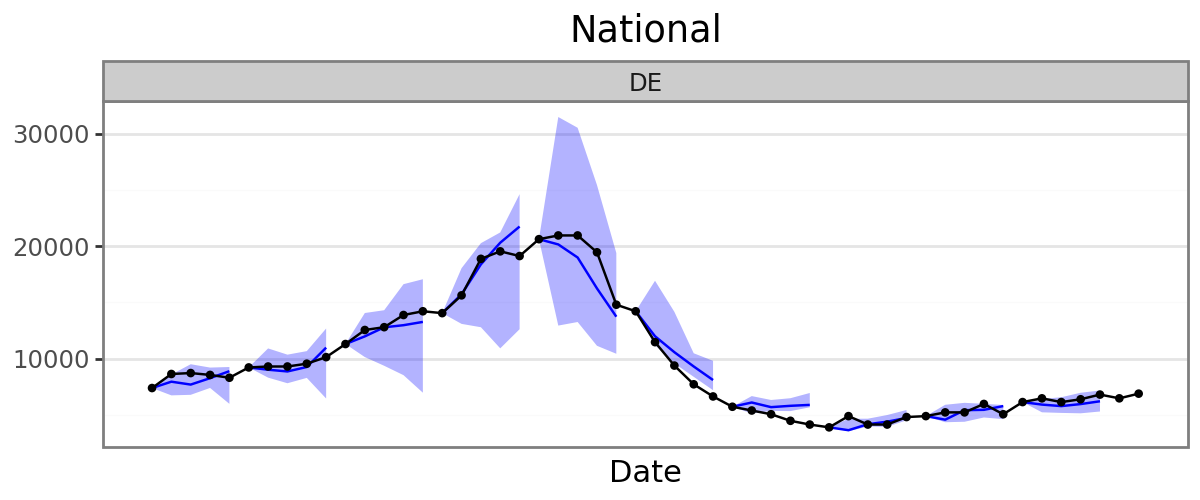

In [105]:
# global, no covariates (best) 

plot_forecasts(df_plot, 'national', 1)

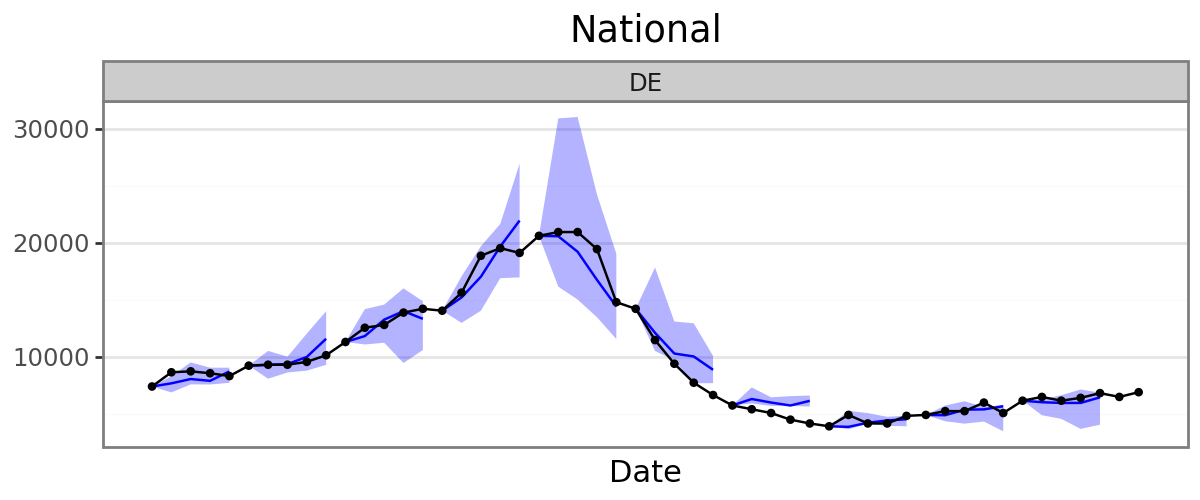

In [95]:
# global, no covariates 

plot_forecasts(df_plot, 'national', 1)

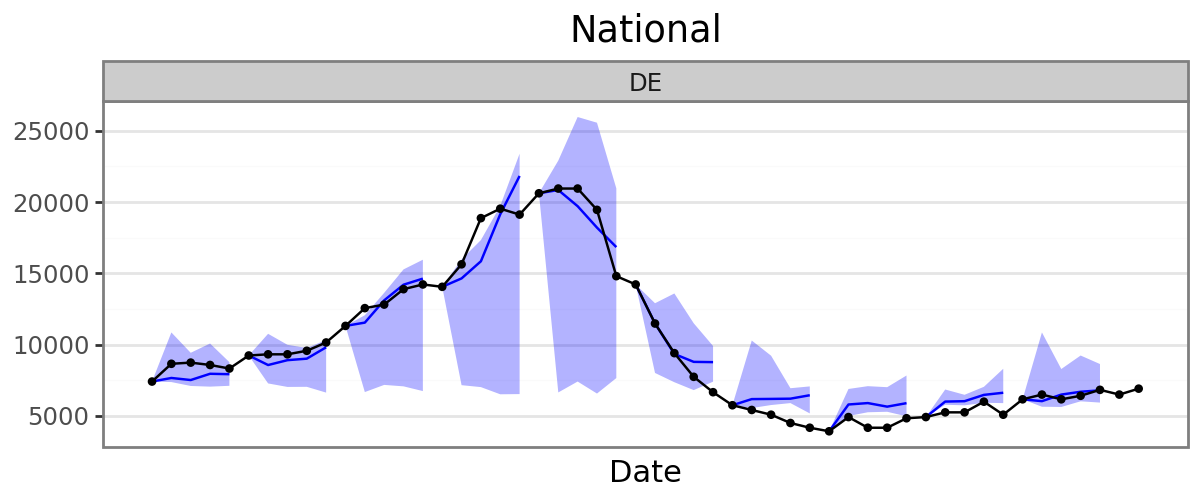

In [80]:
# multivariate, covariates 

plot_forecasts(df_plot, 'national', 1)

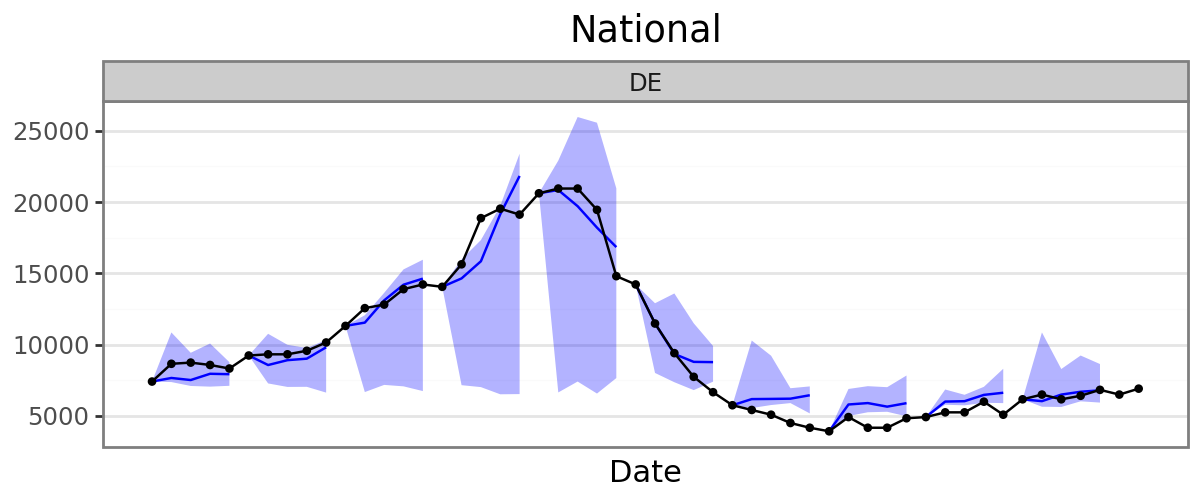

In [80]:
# multivariate, covariates 

plot_forecasts(df_plot, 'national', 1)

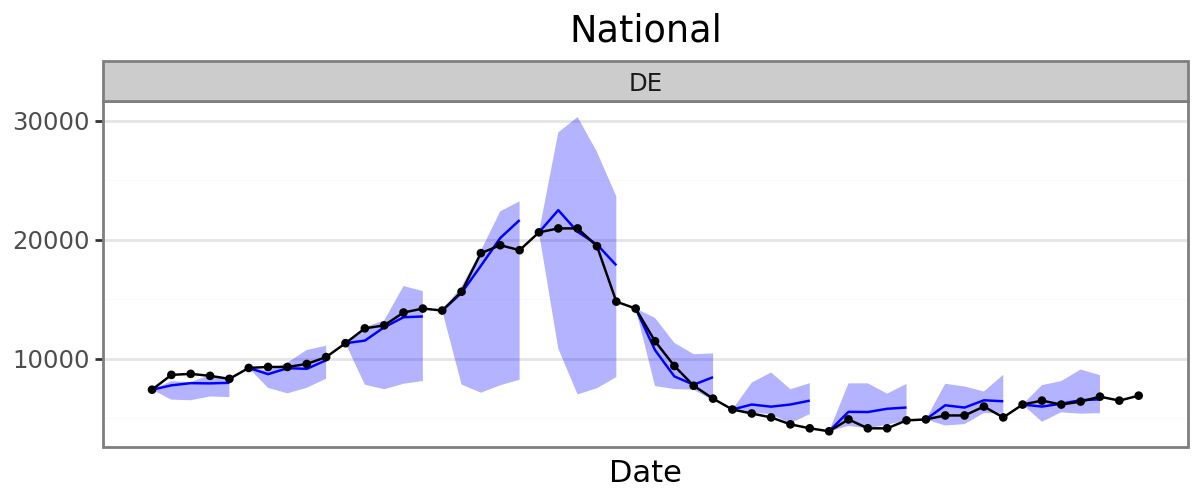

In [56]:
# multivariate, no covariates 

plot_forecasts(df_plot, 'national', 1)

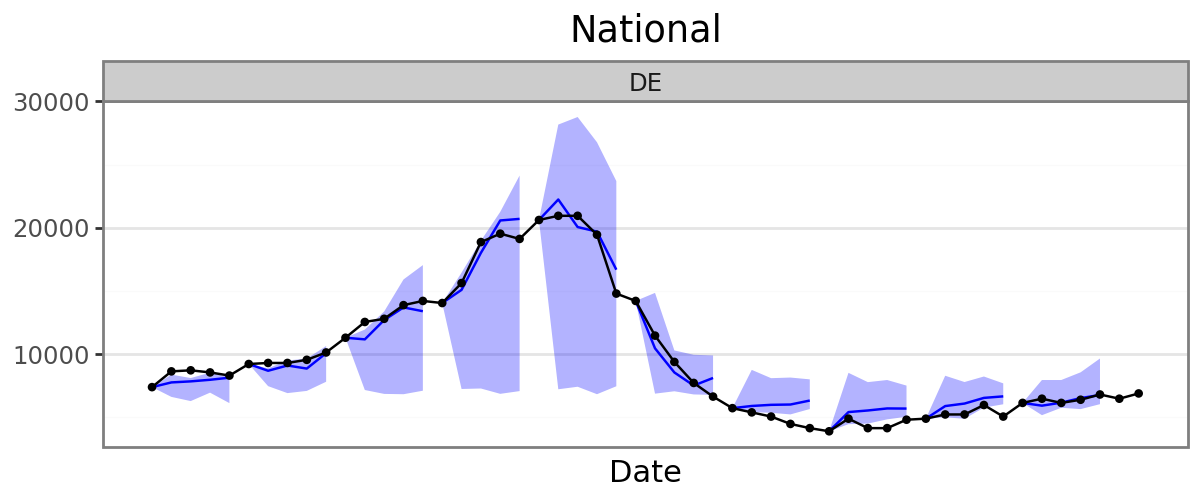

In [40]:
# multivariate, no covariates (best)
plot_forecasts(df_plot, 'national', 1)

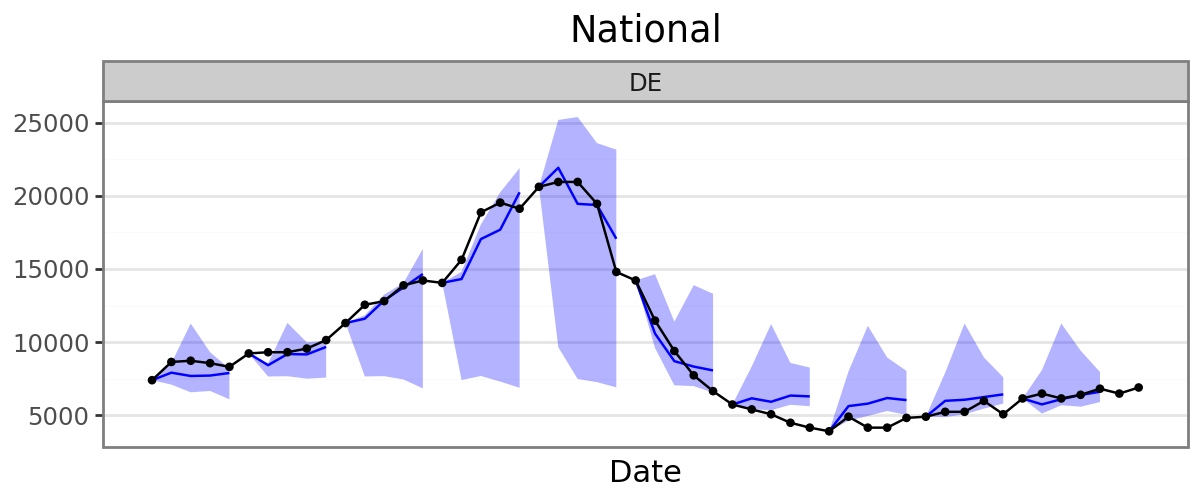

In [45]:
# multivariate, covariates (best)
plot_forecasts(df_plot, 'national', 1)

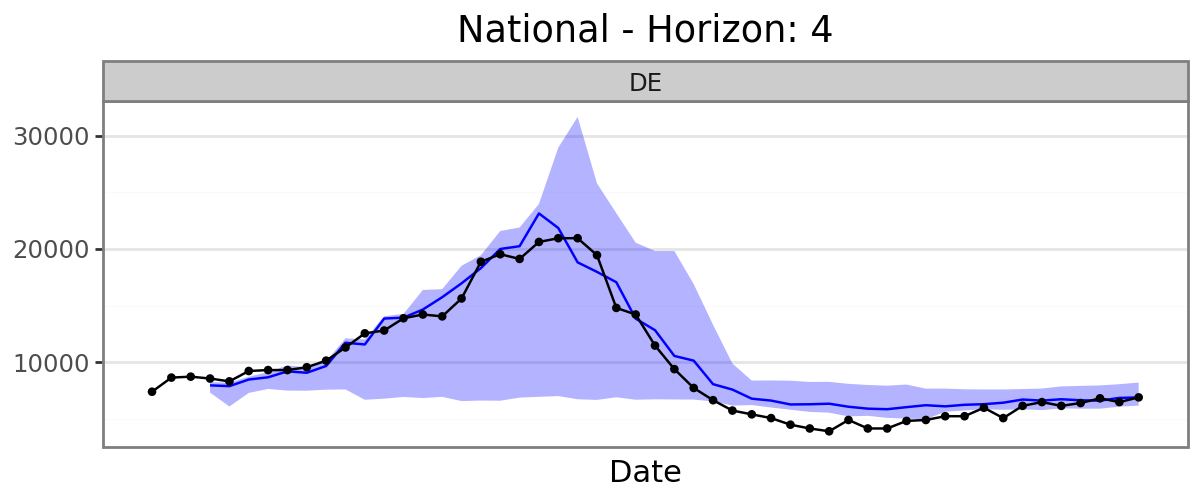

In [68]:
# multivariate, covariates
plot_forecasts(df_plot, 'national', horizon=4)

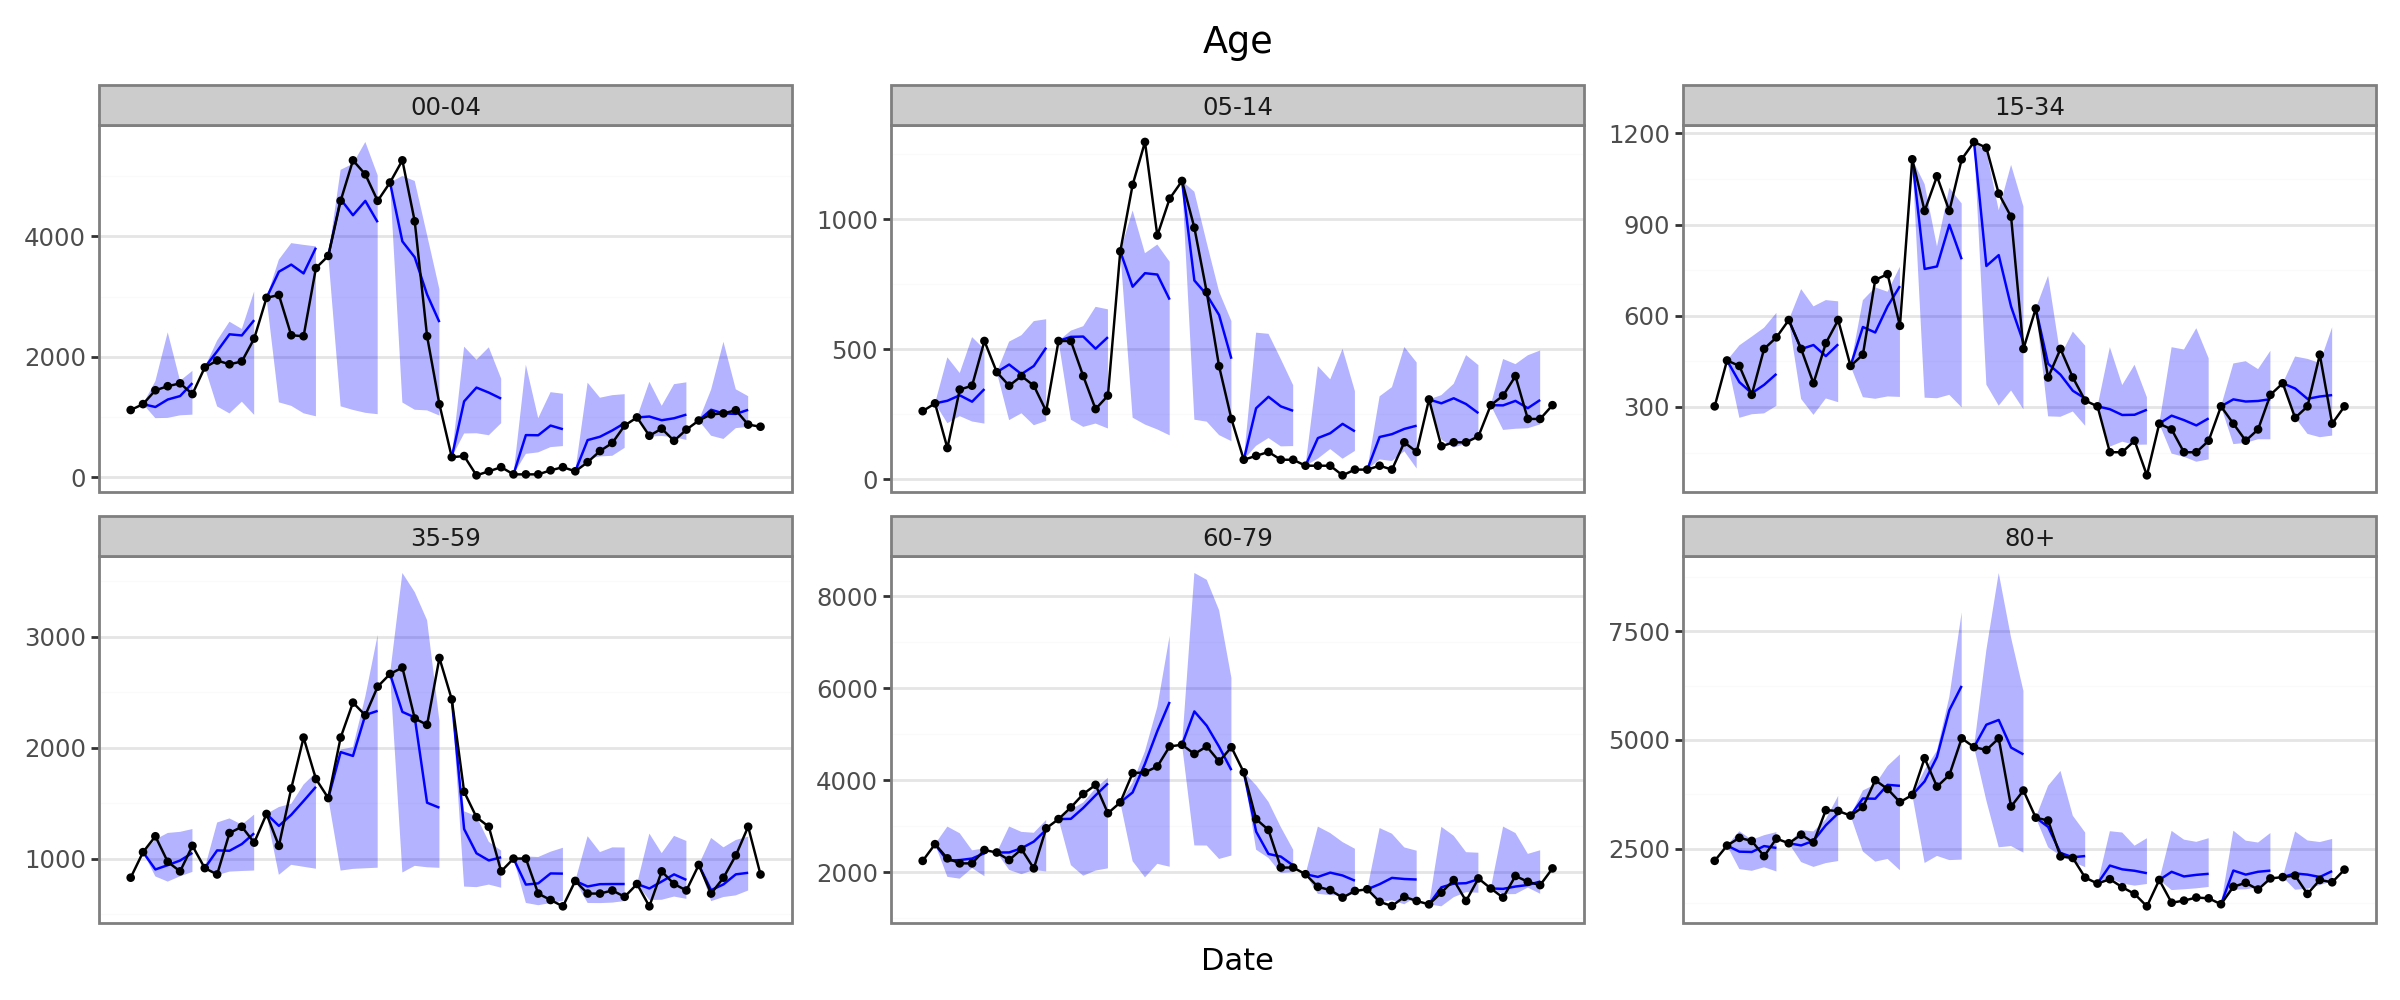

In [64]:
# multivariate, covariates
plot_forecasts(df_plot, 'age', 2)

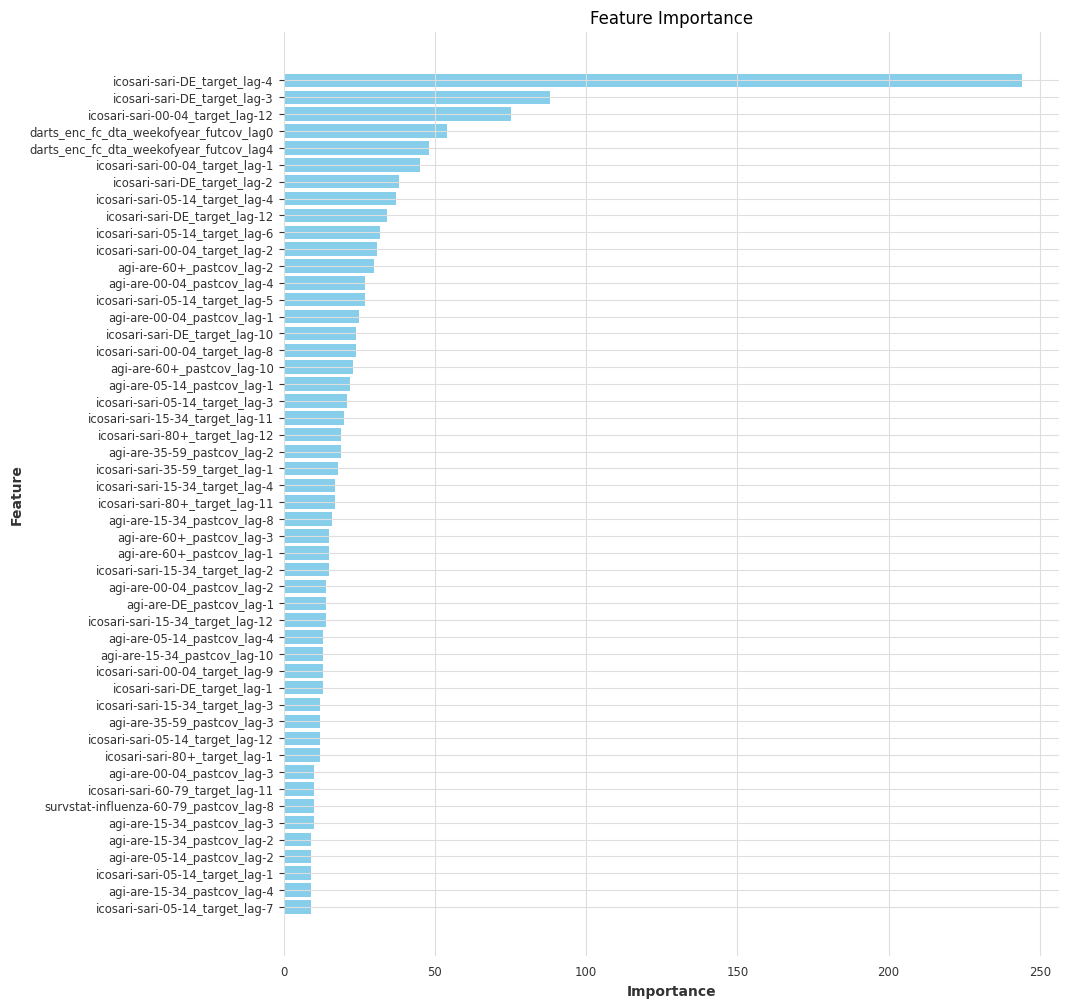

In [63]:
plot_importance_lgbm(model, horizon=0, max_features=50, y_size=12)

In [57]:
model.lagged_label_names

['icosari-sari-DE_target_hrz0',
 'icosari-sari-00-04_target_hrz0',
 'icosari-sari-05-14_target_hrz0',
 'icosari-sari-15-34_target_hrz0',
 'icosari-sari-35-59_target_hrz0',
 'icosari-sari-60-79_target_hrz0',
 'icosari-sari-80+_target_hrz0',
 'icosari-sari-DE_target_hrz1',
 'icosari-sari-00-04_target_hrz1',
 'icosari-sari-05-14_target_hrz1',
 'icosari-sari-15-34_target_hrz1',
 'icosari-sari-35-59_target_hrz1',
 'icosari-sari-60-79_target_hrz1',
 'icosari-sari-80+_target_hrz1',
 'icosari-sari-DE_target_hrz2',
 'icosari-sari-00-04_target_hrz2',
 'icosari-sari-05-14_target_hrz2',
 'icosari-sari-15-34_target_hrz2',
 'icosari-sari-35-59_target_hrz2',
 'icosari-sari-60-79_target_hrz2',
 'icosari-sari-80+_target_hrz2',
 'icosari-sari-DE_target_hrz3',
 'icosari-sari-00-04_target_hrz3',
 'icosari-sari-05-14_target_hrz3',
 'icosari-sari-15-34_target_hrz3',
 'icosari-sari-35-59_target_hrz3',
 'icosari-sari-60-79_target_hrz3',
 'icosari-sari-80+_target_hrz3']

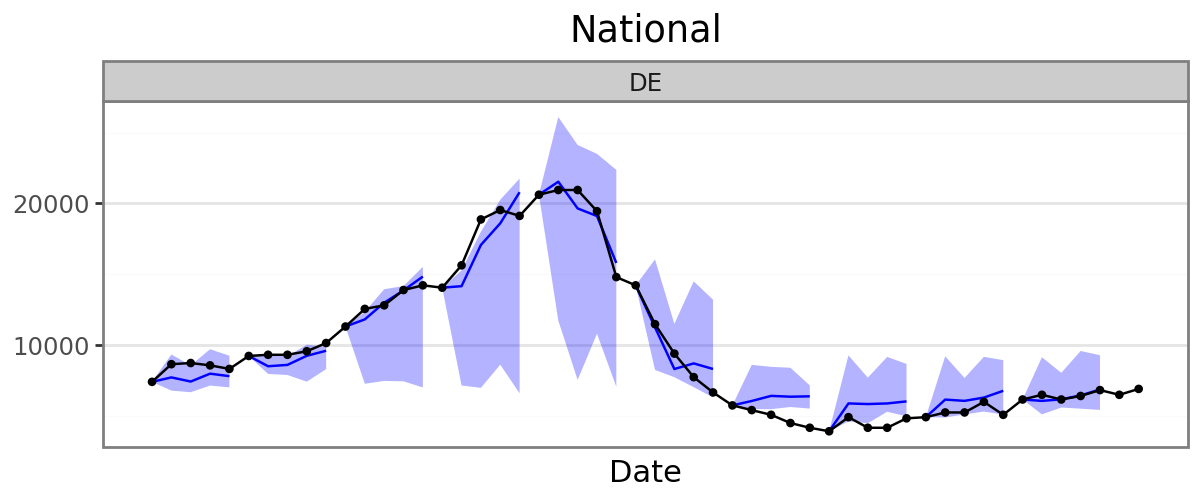

In [34]:
# multivariate, covariates
plot_forecasts(df_plot, 'national', 1)

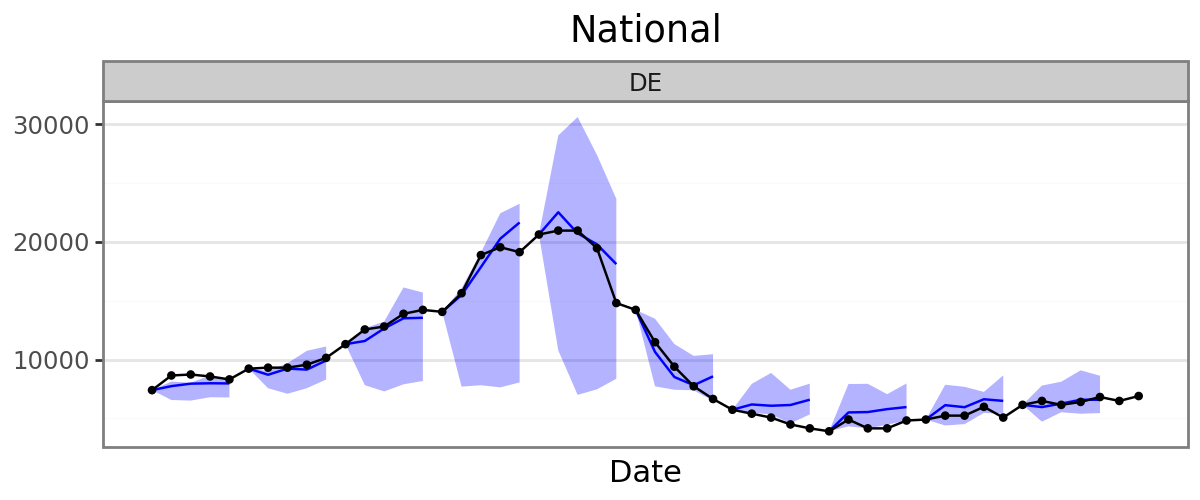

In [21]:
# multivariate, no covariates
plot_forecasts(df_plot, 'national', 1)

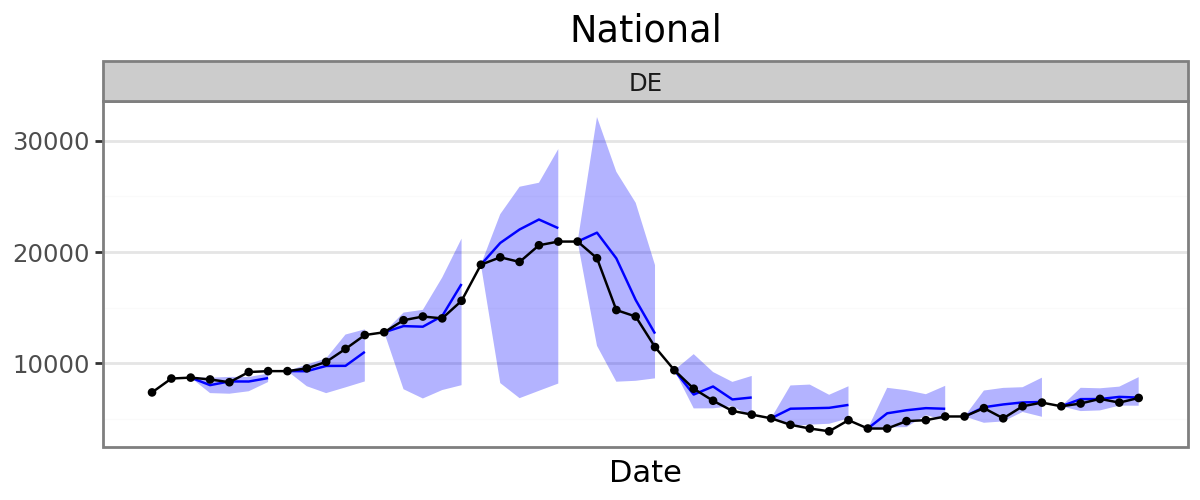

In [23]:
plot_forecasts(df_plot, 'national', 3)

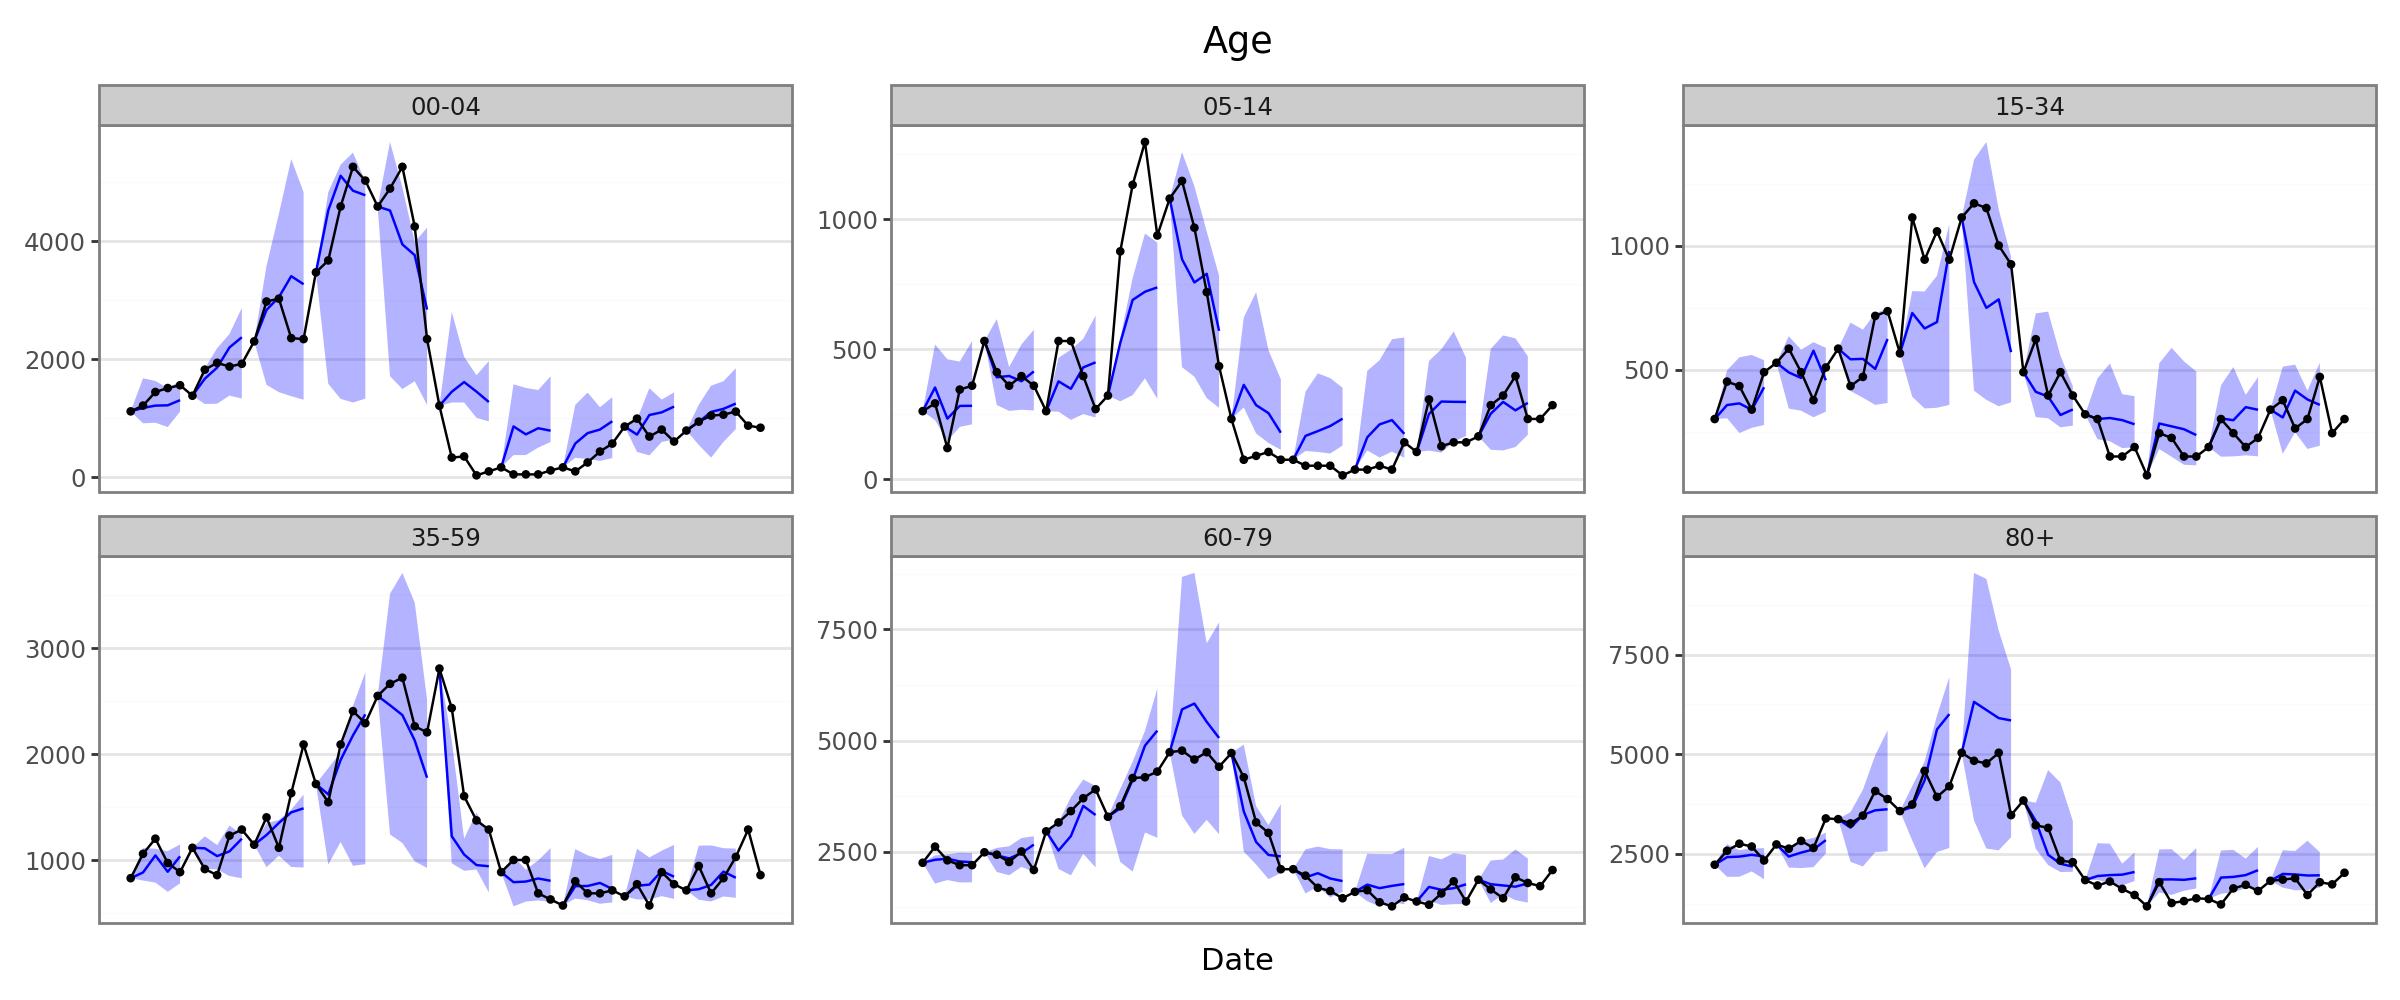

In [24]:
plot_forecasts(df_plot, 'age', 1)

In [30]:
def plot_importance_lgbm(model, horizon=0, max_features=None, y_size=8):
    # Sample data (replace these with actual data)
    feature_importances = model.model.estimators_[horizon].feature_importances_
    feature_names = model.lagged_feature_names

    # Create a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    if max_features:
        feature_importance_df = feature_importance_df.head(max_features)
    
    plt.figure(figsize=(10, y_size))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

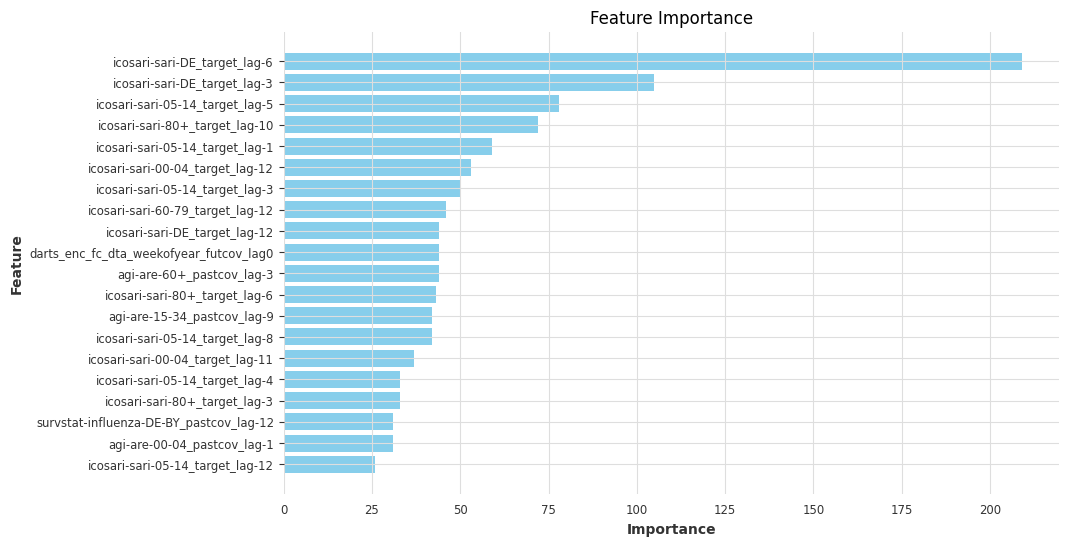

In [38]:
plot_importance_lgbm(model, horizon=2, max_features=20, y_size=6)

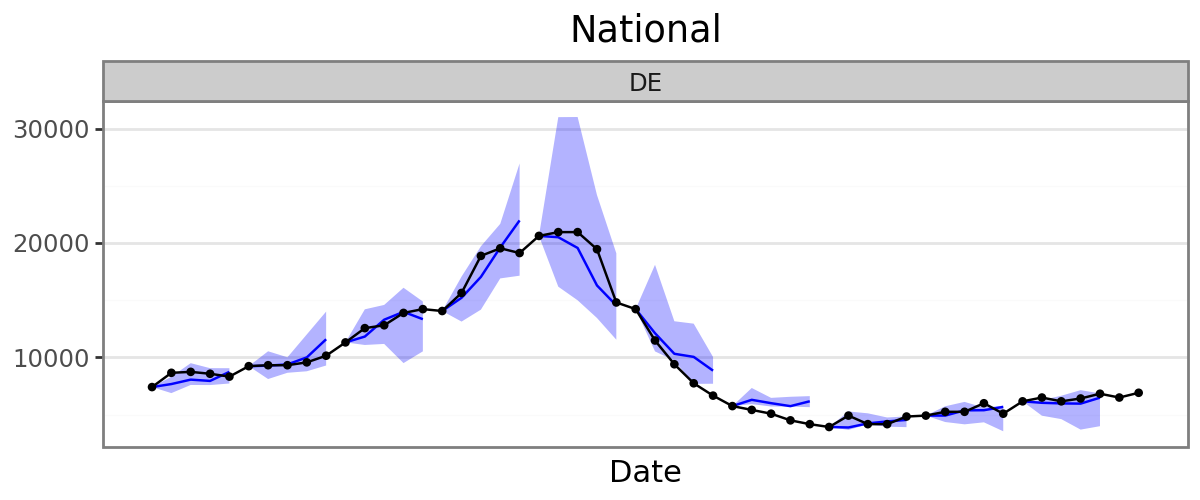

In [75]:
plot_forecasts(df_plot, 'national', 1)

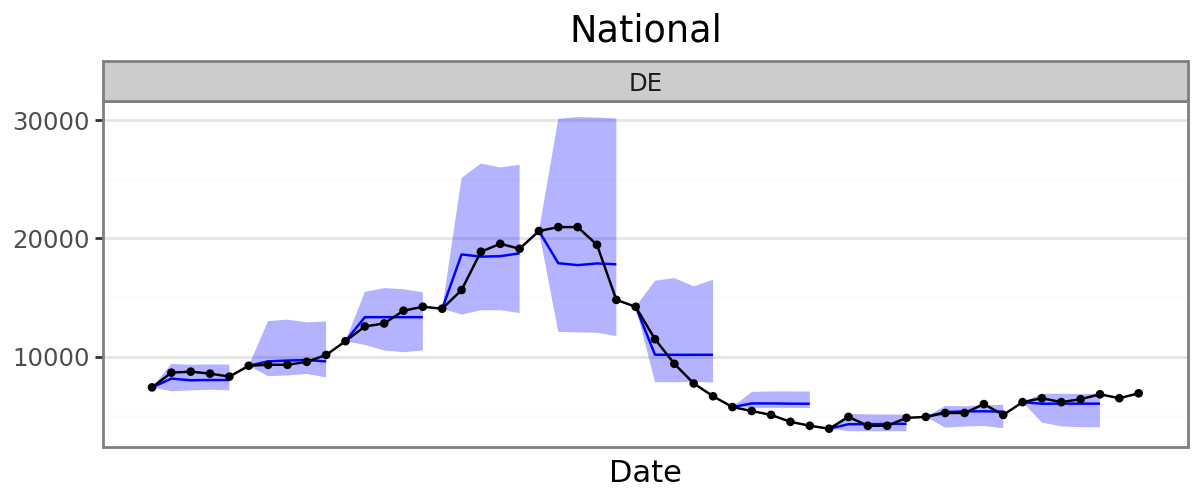

In [68]:
plot_forecasts(df_plot, 'national', 1)

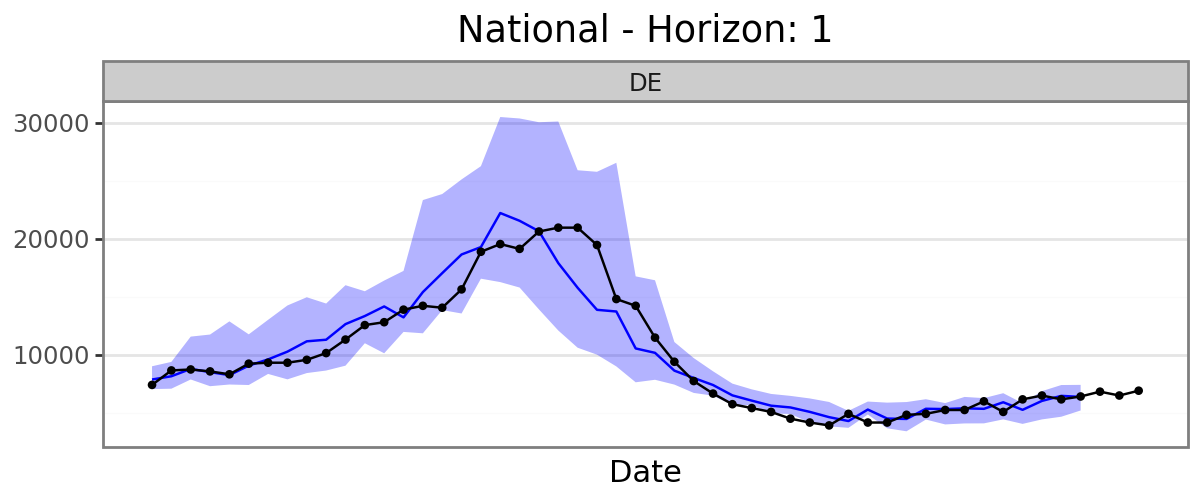

In [66]:
plot_forecasts(df_plot, 'national', horizon=1)

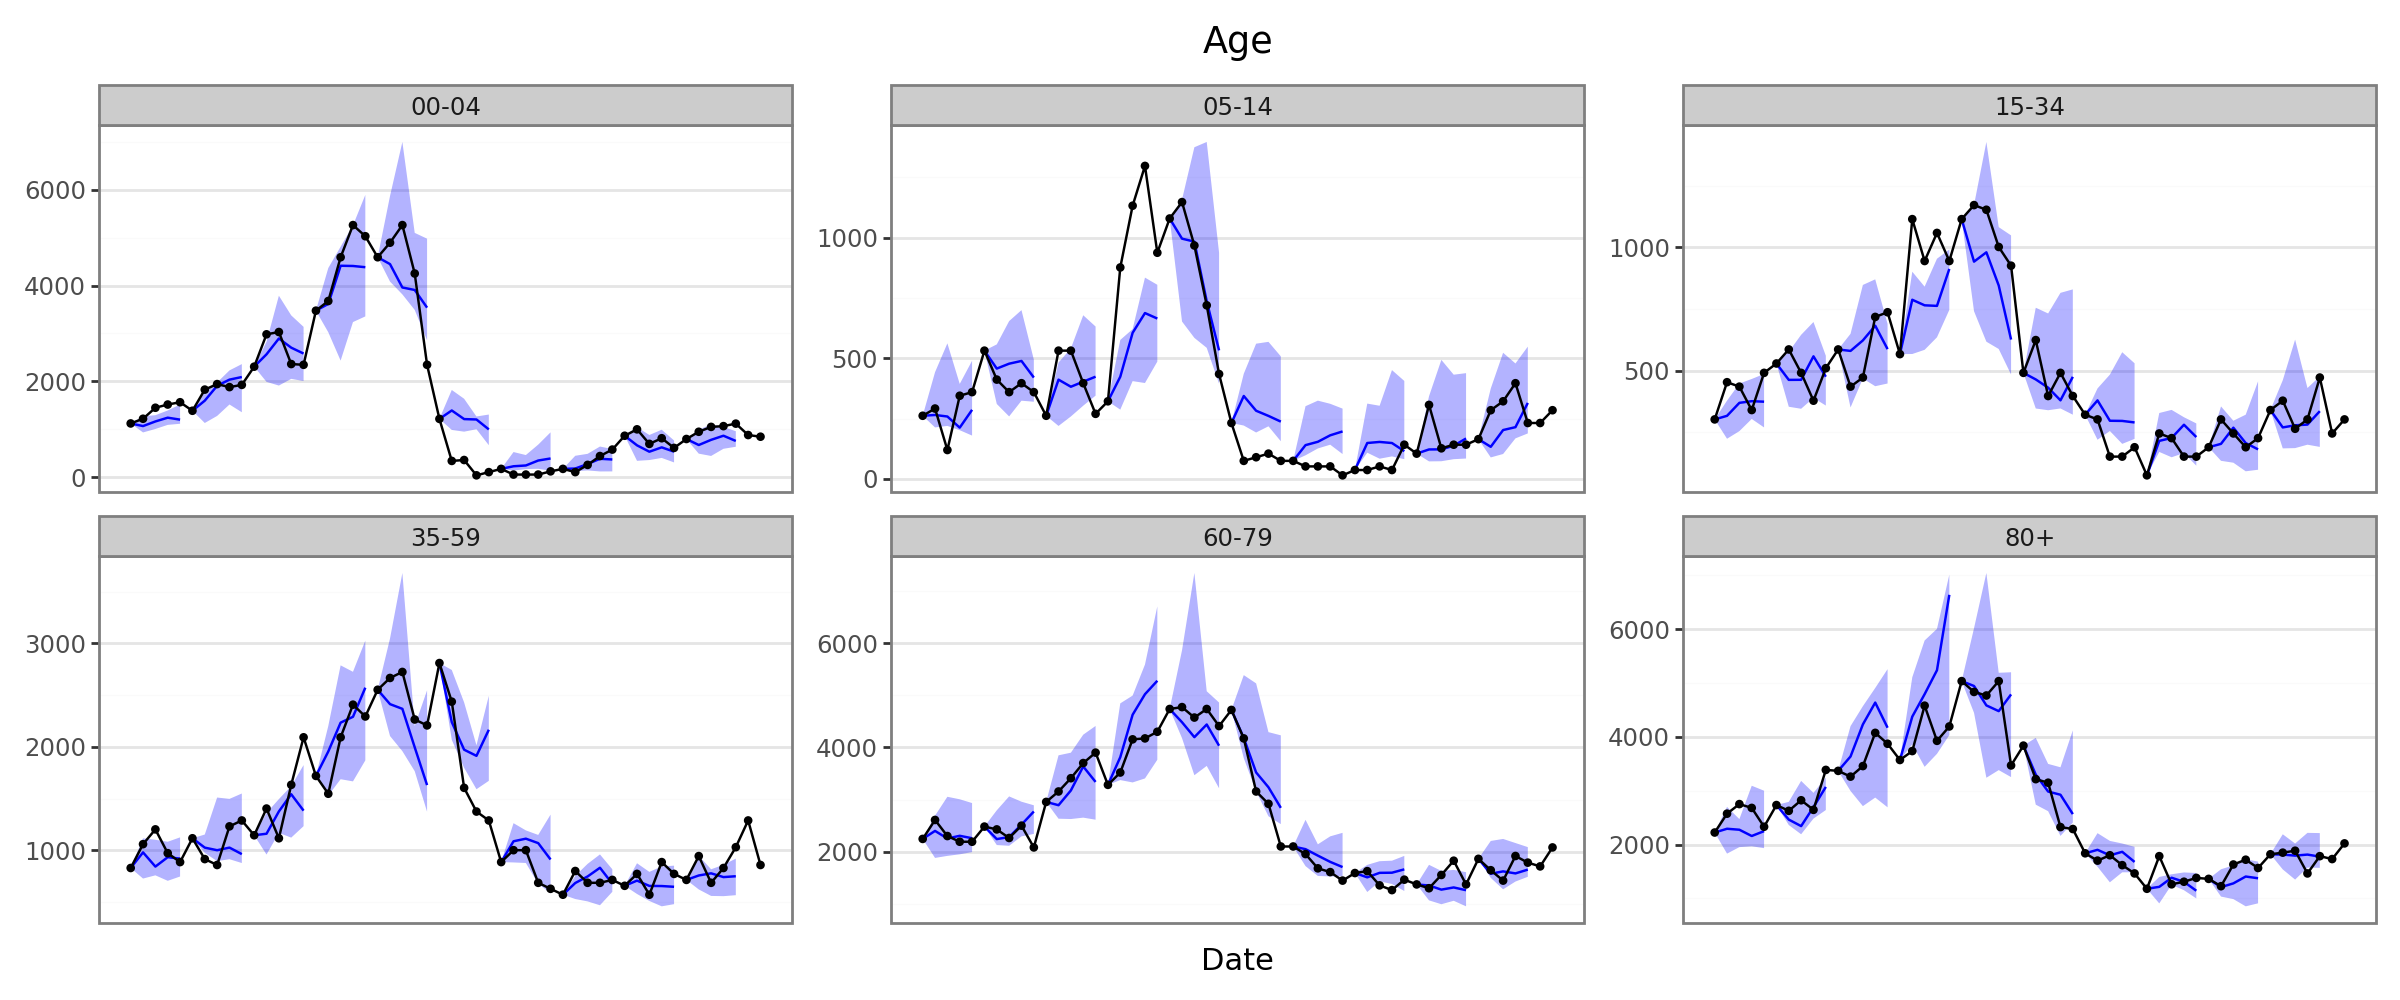

In [76]:
plot_forecasts(df_plot, 'age', 1)

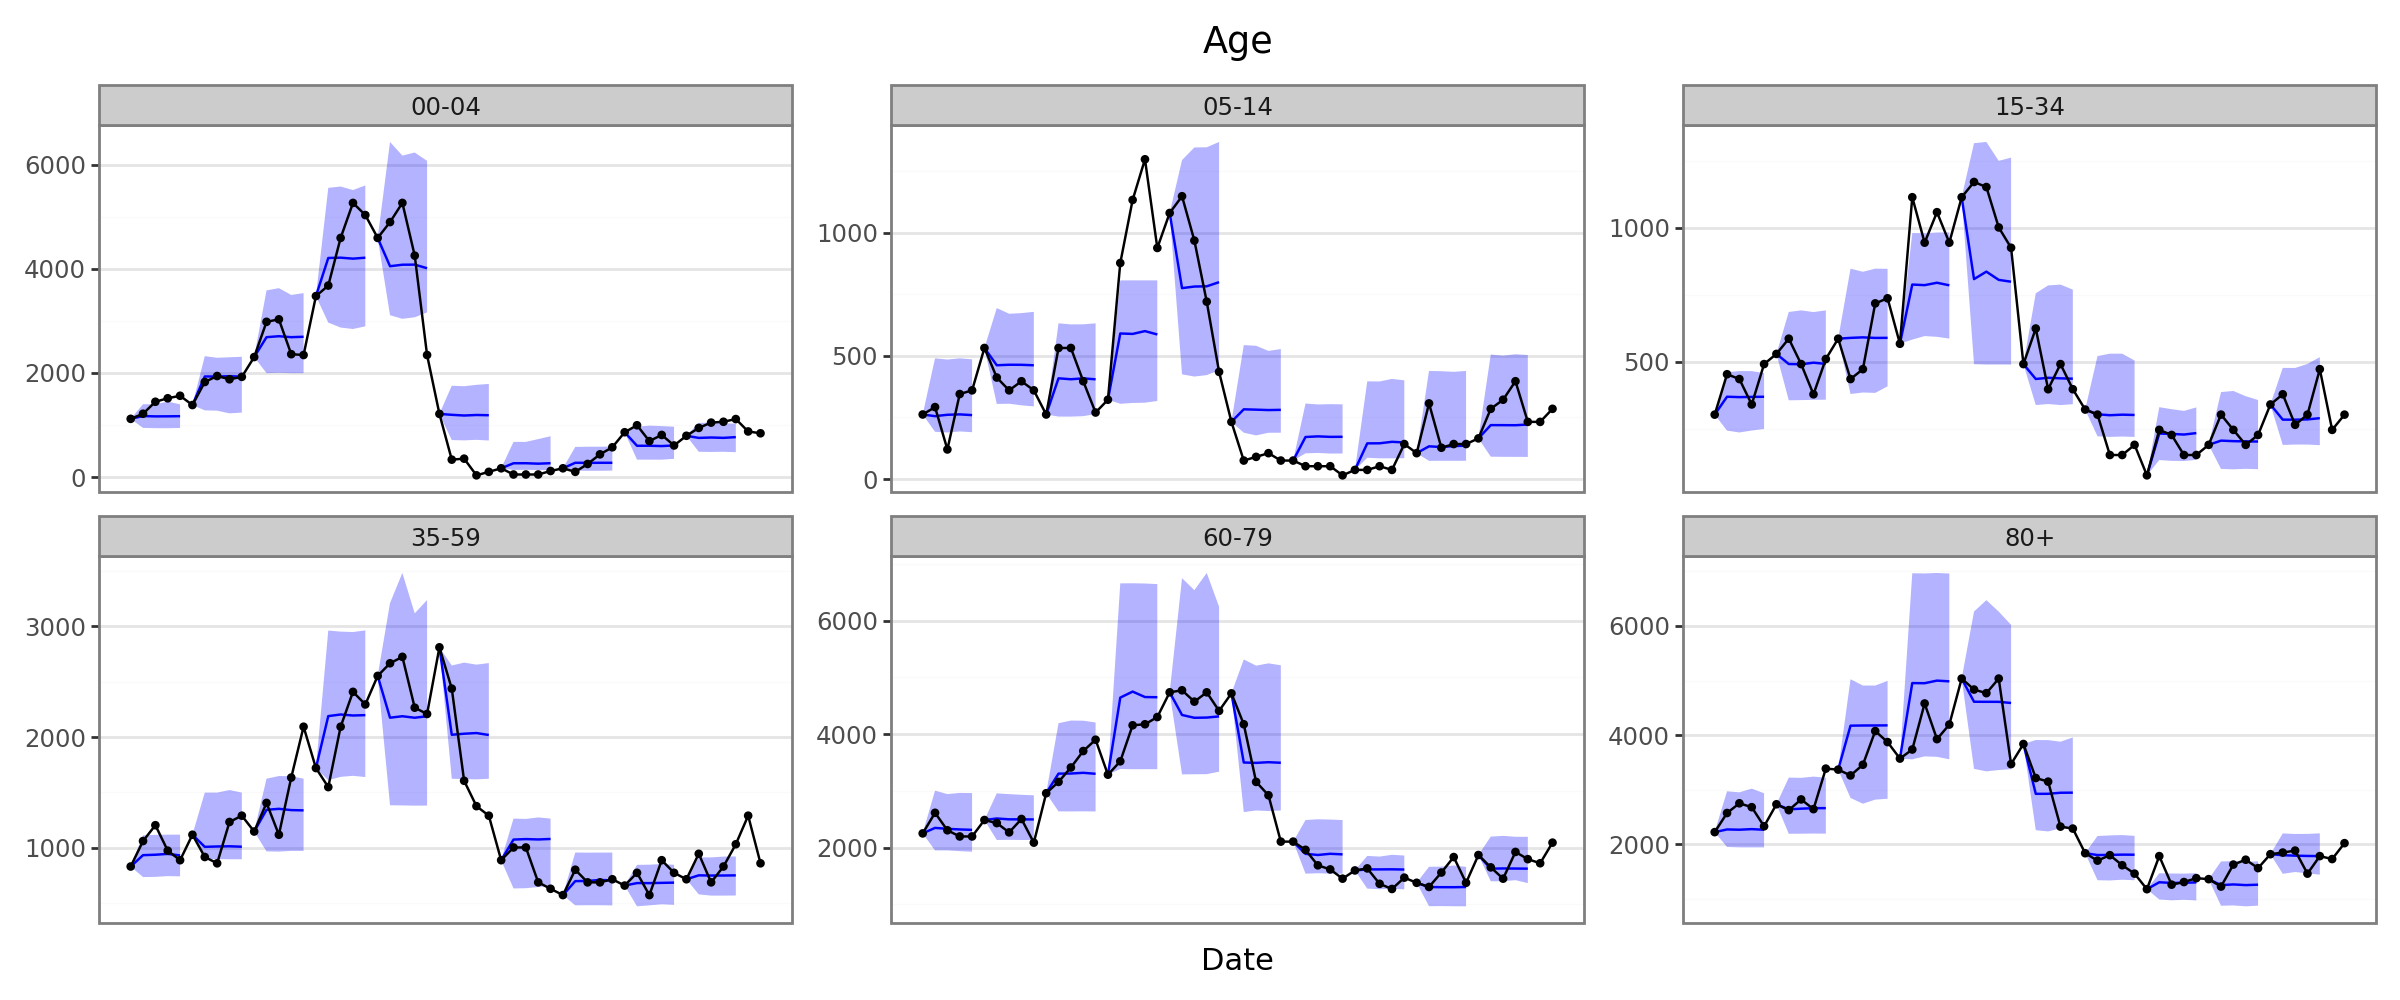

In [67]:
plot_forecasts(df_plot, 'age', 1)